# Eligibility for mobilization

Objective:

* Restrict the analysis to the first 72 hours of intubation and business hours (8am-5pm).
* Determine the windows of opportunity to mobilize patients on ventilators per two sets of criteria (Patel et al. and TEAM).

Criteria for Safe Therapy:

1. Patel et al. Criteria:

* Mean arterial blood pressure: 65-110 mm Hg
* Systolic blood pressure: ≤ 200 mm Hg
* Heart rate: 40-130 beats per minute
* Respiratory rate: 5-40 breaths per minute
* Pulse oximetry: ≥ 88%

2. TEAM Study Criteria:

* Heart rate: ≤ 150 bpm
* Most recent lactate: ≤ 4.0 mmol/L
* Noradrenaline infusion rate: ≤ 0.2 mcg/kg/min, OR
* Noradrenaline infusion rate: 0.1-0.2 mcg/kg/min (without an increase in the infusion rate of more than 25% in the last 6 hours)
* Sufficient respiratory stability:
    *  FiO2: ≤ 0.6
    *  PEEP: ≤ 16 cm H2O
* Current respiratory rate: ≤ 45

3. Consensus criteria

* Green Criteria
    * Respiratory
        * Saturation  90% and
        * Respiratory rate ≤ 30 breaths/min
        * Current FiO2 ≤ 0.6 and
        * PEEP≤ 10cm H20
    * Cardiovascular:
        * Blood pressure greater than lower limit of target range (MAP 65+) while on no or low level of support (low support- define as <0.1 μg/kg/min of Norepi equivalents)
        * Heart rate <120 beats/min
* Yellow Criteria
    * Respiratory
        * Current FiO2 >0.6
        * Respiratory rate >30breaths/min
        * PEEP >10cm H20
    * Cardiovascular
        * Blood pressure greater than lower limit of target range (MAP 65+) while receiving moderate level of support (medium-define as 0.1–0.3 μg/kg/min of Norepi equivalents)
        * Heart rate 120-150 beats/min
        * Shock of any cause with lactate >4mmol/L
* Red Criteria
    * Respiratory
        * Sat <90%
    * Cardiovascular
        * Below target MAP despite support (MAP <65) or
        * greater than lower limit MAP (MAP 65+) but on high level support (high defined as >0.3 μg/kg/min of Norepi equivalents)
        * IV therapy for hypertensive emergency (SBP >200mmHg or MAP >110 and on nicardipine, nitroprusside, or clevidipine gtt)
        * HR >150 bpm
        * Bradycardia <40

## Load Libraries

In [86]:
import sys
import os
os.chdir('..')  # Move up one directory level to the root
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# install pyarrow to work with parquet files
import pyarrow as pa
import pyarrow.parquet as pq

import random
import warnings
import duckdb

## User Input

In [87]:
## Enter your directory path with rclif folder
root_location = '/Users/kavenchhikara/Desktop/CLIF/CLIF-1.0-UCMC'
# either parquet or csv only
filetype = 'parquet'
site_name='UCMC'

In [88]:
race_map = {
    'White': 'White',
    'Black or African American': 'Black',
    'Black or African-American': 'Black',
    'Asian': 'Asian',
    'Other': 'Others',
    'Unknown': 'Others',
    'Did Not Encounter': 'Others',
    'Refusal': 'Others',
    'American Indian or Alaska Native': 'Others',
    'Native Hawaiian or Other Pacific Islander': 'Others',
    np.nan: 'Others'
}

ethnicity_map = {
    'Not Hispanic or Latino': 'Not Hispanic or Latino',
    'Hispanic or Latino': 'Hispanic or Latino',
    'Did Not Encounter': 'Others',
    'Refusal': 'Others',
    '*Unspecified': 'Others',
    'Not Hispanic': 'Not Hispanic or Latino',
    'Hispanic': 'Hispanic or Latino',
    'Unknown': 'Others',
    np.nan: 'Others'
}

In [89]:
# create output directory
# output_directory = os.path.join(os.getcwd(), 'output')
output_directory = "/Users/kavenchhikara/Desktop/RCLIF/projects/eligibility_for_mobilization/output"
print("Check output directory is correct:", output_directory)
os.makedirs(output_directory, exist_ok=True)

Check output directory is correct: /Users/kavenchhikara/Desktop/RCLIF/projects/eligibility_for_mobilization/output


In [90]:
## Confirm that these are the correct paths
adt_filepath = f"{root_location}/rclif/clif_adt.{filetype}"
encounter_filepath = f"{root_location}/rclif/clif_encounter_demographics_dispo_clean.{filetype}"
limited_filepath = f"{root_location}/rclif/clif_limited_identifiers.{filetype}"
demog_filepath = f"{root_location}/rclif/clif_patient_demographics.{filetype}"
vitals_filepath = f"{root_location}/rclif/clif_vitals.{filetype}"
labs_filepath = f"{root_location}/rclif/clif_labs.{filetype}"
meds_filepath = f"{root_location}/rclif/clif_medication_admin_continuous.{filetype}"
resp_support_filepath = f"{root_location}/rclif/clif_respiratory_support.{filetype}" 

## Common Functions

In [91]:
def read_data(filepath, filetype):
    """
    Read data from file based on file type.
    Parameters:
        filepath (str): Path to the file.
        filetype (str): Type of the file ('csv' or 'parquet').
    Returns:
        DataFrame: DataFrame containing the data.
    """
    start_time = time.time()  # Record the start time
    file_name = os.path.basename(filepath) 
    if filetype == 'csv':
        df = pd.read_csv(filepath)
    elif filetype == 'parquet':
        table = pq.read_table(filepath)
        df = table.to_pandas()
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv' or 'parquet'.")
    
    end_time = time.time()  # Record the end time
    load_time = end_time - start_time  # Calculate the loading time
    
    # Calculate the size of the loaded dataset in MB
    dataset_size_mb = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"File name: {file_name}")
    print(f"Time taken to load the dataset: {load_time:.2f} seconds")
    print(f"Size of the loaded dataset: {dataset_size_mb:.2f} MB\n")
    
    return df
    
def count_unique_encounters(df, encounter_column='encounter_id'):
    """
    Counts the unique encounters in a DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame to analyze.
    encounter_column (str): The name of the column containing encounter IDs (default is 'encounter_id').
    
    Returns:
    int: The number of unique encounters.
    """
    return df[encounter_column].nunique()


def generate_facetgrid_histograms(data, category_column, value_column):
    """
    Generate histograms using seaborn's FacetGrid.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        category_column (str): Name of the column containing categories.
        value_column (str): Name of the column containing values.

    Returns:
        FacetGrid: Seaborn FacetGrid object containing the generated histograms.
    """
    # Create a FacetGrid
    g = sns.FacetGrid(data, col=category_column, col_wrap=6, sharex=False, sharey=False)
    g.map(sns.histplot, value_column, bins=30, color='blue', edgecolor='black')

    # Set titles and labels
    g.set_titles('{col_name}')
    g.set_axis_labels(value_column, 'Frequency')

    # Adjust layout
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Histograms of {value_column} by {category_column}', fontsize=16)

    return g

def standardize_datetime(df):
    """
    Ensure that all *_dttm variables are in the correct format.
    Convert all datetime columns to a specific precision and remove timezone
    Parameters:
        DataFrame: DataFrame containing the data.
    Returns:
        DataFrame: DataFrame containing the data.
    """
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            # Here converting to 'datetime64[ns]' for uniformity and removing timezone with 'tz_convert(None)'
            df[col] = df[col].dt.tz_convert(None) if df[col].dt.tz is not None else df[col]
            # If you need to standardize to UTC and keep the timezone:
            # df[col] = df[col].dt.tz_localize('UTC') if df[col].dt.tz is None else df[col].dt.tz_convert('UTC')
    return df

def get_sql_import(filetype):
    if filetype == 'parquet':
        return 'read_parquet'
    if filetype == 'csv':
        return 'read_csv_auto'

sql_import = get_sql_import(filetype=filetype)

In [92]:
def check_duplicates(df, columns):
    """
    Checks for duplicate rows in a DataFrame based on the combination of specified columns.

    Parameters:
        df (DataFrame): The DataFrame to check.
        columns (list): A list of columns to use for identifying duplicates.

    Returns:
        DataFrame: A DataFrame containing the duplicate rows, if any.
    """
    # Check for duplicates based on the combination of specified columns
    duplicates = df[df.duplicated(subset=columns, keep=False)]
    
    if not duplicates.empty:
        print(f"Found {len(duplicates)} duplicate rows based on columns: {columns}")
    else:
        print(f"No duplicates found based on columns: {columns}")
    
    return duplicates

def remove_duplicates(df, columns, df_name):
    """
    Checks for and removes duplicate rows in a DataFrame based on the combination of specified columns.

    Parameters:
        df (DataFrame): The DataFrame to clean.
        columns (list): A list of columns to use for identifying duplicates.
        df_name (str): The name of the DataFrame (for display purposes).

    Returns:
        DataFrame: The DataFrame with duplicates removed.
    """
    # Check for duplicates based on the combination of specified columns
    initial_count = len(df)
    duplicates = df[df.duplicated(subset=columns, keep=False)]
    
    print(f"Processing DataFrame: {df_name}")
    
    if not duplicates.empty:
        num_duplicates = len(duplicates)
        print(f"Found {num_duplicates} duplicate rows based on columns: {columns}")
        
        # Drop duplicates, keeping the first occurrence
        df_cleaned = df.drop_duplicates(subset=columns, keep='first')
        final_count = len(df_cleaned)
        duplicates_dropped = initial_count - final_count
        
        print(f"Dropped {duplicates_dropped} duplicate rows. New DataFrame has {final_count} rows.")
    else:
        df_cleaned = df
        print(f"No duplicates found based on columns: {columns}.")
    
    # Count the number of unique encounters in the cleaned DataFrame
    unique_encounters = df_cleaned['encounter_id'].nunique()
    print(f"Number of unique encounters in {df_name}: {unique_encounters}\n")
    
    return df_cleaned



## Load data

In [93]:
encounter = read_data(encounter_filepath, filetype)
limited = read_data(limited_filepath, filetype)
demog = read_data(demog_filepath, filetype)
adt = read_data(adt_filepath, filetype)
resp_support_raw = read_data(resp_support_filepath, filetype)
vitals = read_data(vitals_filepath, filetype)
labs = read_data(labs_filepath, filetype)
meds = read_data(meds_filepath, filetype)

# Apply the standardization function to each DataFrame
adt = standardize_datetime(adt)
encounter = standardize_datetime(encounter)
limited = standardize_datetime(limited)
demog = standardize_datetime(demog)

File name: clif_encounter_demographics_dispo_clean.parquet
Time taken to load the dataset: 0.09 seconds
Size of the loaded dataset: 248.24 MB

File name: clif_limited_identifiers.parquet
Time taken to load the dataset: 0.10 seconds
Size of the loaded dataset: 478.71 MB

File name: clif_patient_demographics.parquet
Time taken to load the dataset: 0.45 seconds
Size of the loaded dataset: 817.04 MB

File name: clif_adt.parquet
Time taken to load the dataset: 0.26 seconds
Size of the loaded dataset: 236.60 MB

File name: clif_respiratory_support.parquet
Time taken to load the dataset: 0.39 seconds
Size of the loaded dataset: 1771.07 MB

File name: clif_vitals.parquet
Time taken to load the dataset: 11.27 seconds
Size of the loaded dataset: 27902.08 MB

File name: clif_labs.parquet
Time taken to load the dataset: 3.33 seconds
Size of the loaded dataset: 13992.15 MB

File name: clif_medication_admin_continuous.parquet
Time taken to load the dataset: 0.31 seconds
Size of the loaded dataset: 1

In [94]:
# Check column names and dtypes for each DataFrame
dataframes = {
    "adt": adt,
    "encounter": encounter,
    "limited": limited,
    "demog": demog,
    "adt": adt,
    "resp_support": resp_support_raw,
    "vitals": vitals,
    "labs": labs,
    "meds": meds
}

for name, df in dataframes.items():
    print(f"\n{name.capitalize()} DataFrame:")
    print("\nData types of each column:")
    print(df.dtypes)


Adt DataFrame:

Data types of each column:
patient_id            int32
encounter_id          int32
in_dttm              object
out_dttm             object
location_name        object
location_category    object
dtype: object

Encounter DataFrame:

Data types of each column:
patient_id                int32
encounter_id              int32
age_at_admission        float64
disposition_name         object
disposition_category     object
dtype: object

Limited DataFrame:

Data types of each column:
patient_id                 int32
encounter_id               int32
admission_dttm    datetime64[us]
discharge_dttm    datetime64[us]
birth_date                object
zip_code                  object
dtype: object

Demog DataFrame:

Data types of each column:
patient_id        int32
encounter_id    float64
sex              object
race             object
ethnicity        object
dtype: object

Resp_support DataFrame:

Data types of each column:
patient_id                                int32
encounter

In [95]:
encounter

,patient_id,encounter_id,age_at_admission,disposition_name,disposition_category
0,1,10210637,6.0,Discharged to Home or Self Care (Routine Disch...,Home
1,6,1245635,21.0,Discharged to Home or Self Care (Routine Disch...,Home
2,6,11268344,22.0,Discharged to Home or Self Care (Routine Disch...,Home
3,6,11979360,21.0,Discharged to Home or Self Care (Routine Disch...,Home
4,6,20346665,21.0,Discharged to Home or Self Care (Routine Disch...,Home
...,...,...,...,...,...
1403788,4999994,17201500,3.0,Discharged to Home or Self Care (Routine Disch...,Home
1403789,4999994,19675454,2.0,Discharged to Home or Self Care (Routine Disch...,Home
1403790,4999994,23100362,3.0,Left without being seen,Home
1403791,4999994,26687914,2.0,Left without being seen,Home


## Duplicate check

In [96]:
# Remove duplicates in the 'demog' DataFrame based on 'patient_id' and 'encounter_id'
demog_cleaned = remove_duplicates(demog, ['patient_id', 'encounter_id'], 'demog')
encounter_cleaned = remove_duplicates(encounter, ['patient_id', 'encounter_id'], 'encounter')

# Apply the same logic to other DataFrames:
adt_cleaned = remove_duplicates(adt, ['patient_id', 'encounter_id', 'in_dttm', 'out_dttm', 'location_category'], 'adt')
limited_cleaned = remove_duplicates(limited, ['patient_id', 'encounter_id'], 'limited')

Processing DataFrame: demog
Found 610912 duplicate rows based on columns: ['patient_id', 'encounter_id']
Dropped 305456 duplicate rows. New DataFrame has 3699185 rows.
Number of unique encounters in demog: 3698806

Processing DataFrame: encounter
Found 41119 duplicate rows based on columns: ['patient_id', 'encounter_id']
Dropped 20678 duplicate rows. New DataFrame has 1383115 rows.
Number of unique encounters in encounter: 1383115

Processing DataFrame: adt
Found 701 duplicate rows based on columns: ['patient_id', 'encounter_id', 'in_dttm', 'out_dttm', 'location_category']
Dropped 401 duplicate rows. New DataFrame has 875046 rows.
Number of unique encounters in adt: 415341

Processing DataFrame: limited
Found 610908 duplicate rows based on columns: ['patient_id', 'encounter_id']
Dropped 305454 duplicate rows. New DataFrame has 3693354 rows.
Number of unique encounters in limited: 3693354



## CLIF Respiratory Support Waterfall Carry up+down logic

In [97]:
def process_resp_support(df):
    # Initiate
    print("Initiating waterfall")

    #  Order Data for Filling
    df = df.sort_values(by=['encounter_id', 'recorded_dttm'])
    print("Sorted encounters and recorded time")
    
    #  Fix Missing `device_category`
    print("Fixing device category")
    df['device_category'] = np.where(
        df['device_category'].isna() & df['device_name'].isna() & 
        df['mode_category'].str.contains("Assist Control-Volume Control|SIMV|Pressure Control", na=False),
        'Vent',
        df['device_category']
    )

    # Assigning `Vent` to Missing `device_category` where appropriate
    df['device_category'] = np.where(
        df['device_category'].isna() & ~df['device_name'].str.contains("Trach", na=False) &
        df['tidal_volume_set'].gt(0) & df['resp_rate_set'].gt(0),
        'Vent',
        df['device_category']
    )
    
    df['device_category'] = df.groupby('encounter_id')['device_category'].ffill().bfill()

    df['mode_category'] = np.where(
        df['mode_category'].isna() & ~df['device_name'].str.contains("Trach", na=False) &
        df['tidal_volume_set'].gt(0) & df['resp_rate_set'].gt(0),
        'Assist Control-Volume Control',
        df['mode_category']
    )
    
    # Fill forward and backward `device_name` and `mode_name` within each encounter
    print('Filling forward and backward device_name and mode_name')
    df['device_name'] = df.groupby('encounter_id')['device_name'].ffill().bfill()
    df['mode_name'] = df.groupby('encounter_id')['mode_name'].ffill().bfill()

    # Fill forward and backward `mode_category` within each encounter
    df['mode_category'] = df.groupby('encounter_id')['mode_category'].ffill().bfill()

    # If `fio2_set` is missing and `device_category` is 'room air', set `fio2_set` to 0.21
    print("Filling missing fio2_set where device_category is 'room air'")
    df['fio2_set'] = np.where(df['fio2_set'].isna() & (df['device_category'] == 'room air'), 0.21, df['fio2_set'])

    # Carry forward the remaining variables within each encounter
    print('Carrying forward the remaining variables')
    vars_to_fill = [
        'fio2_set', 'lpm_set', 'tidal_volume_set', 'resp_rate_set',
        'pressure_control_set', 'pressure_support_set', 'flow_rate_set',
        'peak_inspiratory_pressure_set', 'inspiratory_time_set', 'peep_set',
        'tidal_volume_obs', 'resp_rate_obs', 'plateau_pressure_obs',
        'peak_inspiratory_pressure_obs', 'peep_obs', 'minute_vent_obs'
    ]
    df[vars_to_fill] = df.groupby('encounter_id')[vars_to_fill].ffill().bfill()

    # Fill `tracheostomy` (down only)
    print('Filling tracheostomy (down only)')
    df['tracheostomy'] = df.groupby('encounter_id')['tracheostomy'].ffill()

    # Handle Duplicates: Keep the first occurrence
    print('Removing duplicates')
    df = df.drop_duplicates(subset=['encounter_id', 'recorded_dttm'])

    return df

In [98]:
resp_support = process_resp_support(resp_support_raw)

Initiating waterfall
Sorted encounters and recorded time
Fixing device category
Filling forward and backward device_name and mode_name
Filling missing fio2_set where device_category is 'room air'
Carrying forward the remaining variables
Filling tracheostomy (down only)
Removing duplicates


## Cohort Identification

CHANGED THIS FOR COVID DATAMART--- Dataset to prepare for January 1, 2021 - December 31, 2023 admissions for critically ill adults. 

#### Step 1: Filter Admissions for March 1, 2020 - March 31, 2022 for Critically Ill Adults

In [99]:
# Ensure datetime format is correct
limited['admission_dttm'] = pd.to_datetime(limited['admission_dttm'])

# Step 1: Filter admissions between January 1, 2022 and December 31, 2023
admissions_filtered = limited[
    (limited['admission_dttm'] >= "2020-03-01") & 
    (limited['admission_dttm'] <= "2022-03-31")
]

# Merge with encounter table and filter for adults (age >= 18)
cohort = admissions_filtered.merge(encounter, on=["patient_id", "encounter_id"])
cohort = cohort[cohort['age_at_admission'] >= 18]
cohort = cohort[['encounter_id']].drop_duplicates()

# Sanity check: Number of unique encounters after filtering
print(f"Number of unique encounters after filtering by date and age: {count_unique_encounters(cohort, 'encounter_id')}")


Number of unique encounters after filtering by date and age: 632718


#### Step 2: Identify Encounters that were ever on Vent

In [100]:
# Step 2: Filter respiratory support table for ventilator usage
ventilator_usage = resp_support[resp_support['device_category'].str.contains("Vent", case=False, na=False)]

# Get unique encounter IDs of patients who have been on a ventilator
ventilator_encounters = ventilator_usage[['encounter_id']].drop_duplicates()

# Merge with cohort to get admission details for patients who were on a ventilator
cohort_on_vent = ventilator_encounters.merge(cohort, on='encounter_id', how='inner')

# Sanity check: Number of unique encounters after filtering for ventilator usage
print(f"Number of unique encounters after filtering for ventilator usage: {cohort_on_vent['encounter_id'].nunique()}")

Number of unique encounters after filtering for ventilator usage: 6384


## Respiratory support


In [101]:
columns_to_keep = [
    'encounter_id', 'recorded_dttm', 'device_name','device_category',
    'mode_name', 'mode_category' , 'tracheostomy',
    'fio2_set', 'lpm_set', 'peep_set', 'peep_obs', 
    'resp_rate_obs', 'resp_rate_set'
]
resp_filtered = resp_support[columns_to_keep]
# Apply thresholds and replace values outside these with NaN using .loc[]
resp_filtered.loc[:, 'fio2_set'] = resp_filtered['fio2_set'].where(resp_filtered['fio2_set'].between(0.21, 1, inclusive='both'), np.nan)
resp_filtered.loc[:, 'resp_rate_set'] = resp_filtered['resp_rate_set'].where(resp_filtered['resp_rate_set'].between(0, 60, inclusive='both'), np.nan)
resp_filtered.loc[:, 'peep_set'] = resp_filtered['peep_set'].where(resp_filtered['peep_set'].between(0, 50, inclusive='both'), np.nan)
resp_filtered.loc[:, 'resp_rate_obs'] = resp_filtered['resp_rate_obs'].where(resp_filtered['resp_rate_obs'].between(0, 100, inclusive='both'), np.nan)
resp_filtered.loc[:, 'peep_obs'] = resp_filtered['peep_obs'].where(resp_filtered['peep_obs'].between(0, 70, inclusive='both'), np.nan)
resp_filtered.loc[:, 'lpm_set'] = resp_filtered['lpm_set'].where(resp_filtered['lpm_set'].between(0, 60, inclusive='both'), np.nan)

# Convert recorded_dttm to datetime
resp_filtered.loc[:, 'recorded_dttm'] = pd.to_datetime(resp_filtered['recorded_dttm'])

In [102]:
# Step 1: Filter the respiratory support table to include only the encounters in the final cohort
resp_filtered = resp_filtered[resp_filtered['encounter_id'].isin(cohort_on_vent['encounter_id'])]

# Step 2: Sort by encounter_id and recorded_dttm to ensure correct chronological order
resp_filtered = resp_filtered.sort_values(by=['encounter_id', 'recorded_dttm'])

# Step 3: Create the on_vent flag
resp_filtered['on_vent'] = resp_filtered['device_category'].str.contains("Vent", case=False, na=False).astype(int)

# Step 4: Calculate vent_start_time and vent_end_time for each encounter based on the 'Vent' category
vent_start_end = resp_filtered[resp_filtered['on_vent'] == 1].groupby('encounter_id').agg(
    vent_start_time=('recorded_dttm', 'min'),
    vent_end_time=('recorded_dttm', 'max')
).reset_index()

In [103]:
vent_start_end

,encounter_id,vent_start_time,vent_end_time
0,10932,2021-12-19 03:05:00,2021-12-20 13:00:00
1,26255,2020-07-07 22:15:00,2020-07-10 11:00:00
2,39566,2022-02-17 08:59:00,2022-02-19 08:09:00
3,46076,2021-06-18 20:00:00,2021-06-23 09:00:00
4,46286,2021-11-16 09:47:00,2021-11-17 20:00:00
...,...,...,...
6379,29993729,2022-02-01 16:40:00,2022-02-02 11:00:00
6380,29993999,2020-11-20 12:38:00,2020-11-20 16:00:00
6381,29997532,2020-09-01 04:27:00,2020-09-05 11:00:00
6382,29999119,2022-01-08 01:30:00,2022-02-16 11:00:00


In [104]:
print("unique encounters in vent_start_end", count_unique_encounters(vent_start_end))
print("unique encounters in resp filtered", count_unique_encounters(resp_filtered))

unique encounters in vent_start_end 6384
unique encounters in resp filtered 6384


In [105]:
# Step 5: Merge the vent_start_end information back into resp_filtered
resp_filtered = resp_filtered.merge(vent_start_end, on='encounter_id', how='left')

In [106]:
resp_filtered

,encounter_id,recorded_dttm,device_name,device_category,mode_name,mode_category,tracheostomy,fio2_set,lpm_set,peep_set,peep_obs,resp_rate_obs,resp_rate_set,on_vent,vent_start_time,vent_end_time
0,10932,2021-12-19 02:54:23,Non-Rebreather,Face Mask,A/C Volume,Assist Control-Volume Control,0.0,1.00,15.0,5.0,5.0,22.0,16.0,0,2021-12-19 03:05:00,2021-12-20 13:00:00
1,10932,2021-12-19 02:57:27,NRB Mask,Face Mask,A/C Volume,Assist Control-Volume Control,0.0,1.00,15.0,5.0,5.0,22.0,16.0,0,2021-12-19 03:05:00,2021-12-20 13:00:00
2,10932,2021-12-19 03:05:00,NRB Mask,Vent,A/C Volume,Assist Control-Volume Control,0.0,1.00,15.0,5.0,5.0,22.0,16.0,1,2021-12-19 03:05:00,2021-12-20 13:00:00
3,10932,2021-12-19 08:00:00,NRB Mask,Vent,A/C Volume,Assist Control-Volume Control,0.0,0.35,15.0,5.0,5.0,22.0,13.0,1,2021-12-19 03:05:00,2021-12-20 13:00:00
4,10932,2021-12-19 09:00:00,NRB Mask,Vent,A/C Volume,Assist Control-Volume Control,0.0,0.35,15.0,5.0,5.0,22.0,13.0,1,2021-12-19 03:05:00,2021-12-20 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124143,29999273,2021-11-26 19:22:00,Room Air,Room Air,CPAP,Pressure Support/CPAP,0.0,0.40,2.0,NaN,NaN,20.0,12.0,0,2021-11-24 04:52:00,2021-11-24 04:52:00
1124144,29999273,2021-11-26 23:30:00,Room Air,Room Air,CPAP,Pressure Support/CPAP,0.0,0.40,2.0,NaN,NaN,20.0,12.0,0,2021-11-24 04:52:00,2021-11-24 04:52:00
1124145,29999273,2021-11-27 03:30:00,Room Air,Room Air,CPAP,Pressure Support/CPAP,0.0,0.40,2.0,NaN,NaN,20.0,12.0,0,2021-11-24 04:52:00,2021-11-24 04:52:00
1124146,29999273,2021-11-27 07:30:00,Nasal Cannula,Nasal Cannula,CPAP,Pressure Support/CPAP,0.0,0.40,2.0,NaN,NaN,20.0,12.0,0,2021-11-24 04:52:00,2021-11-24 04:52:00


In [107]:
resp_cleaned = remove_duplicates(resp_filtered, ['encounter_id', 'recorded_dttm'], 'resp_filtered')

Processing DataFrame: resp_filtered
No duplicates found based on columns: ['encounter_id', 'recorded_dttm'].
Number of unique encounters in resp_filtered: 6384



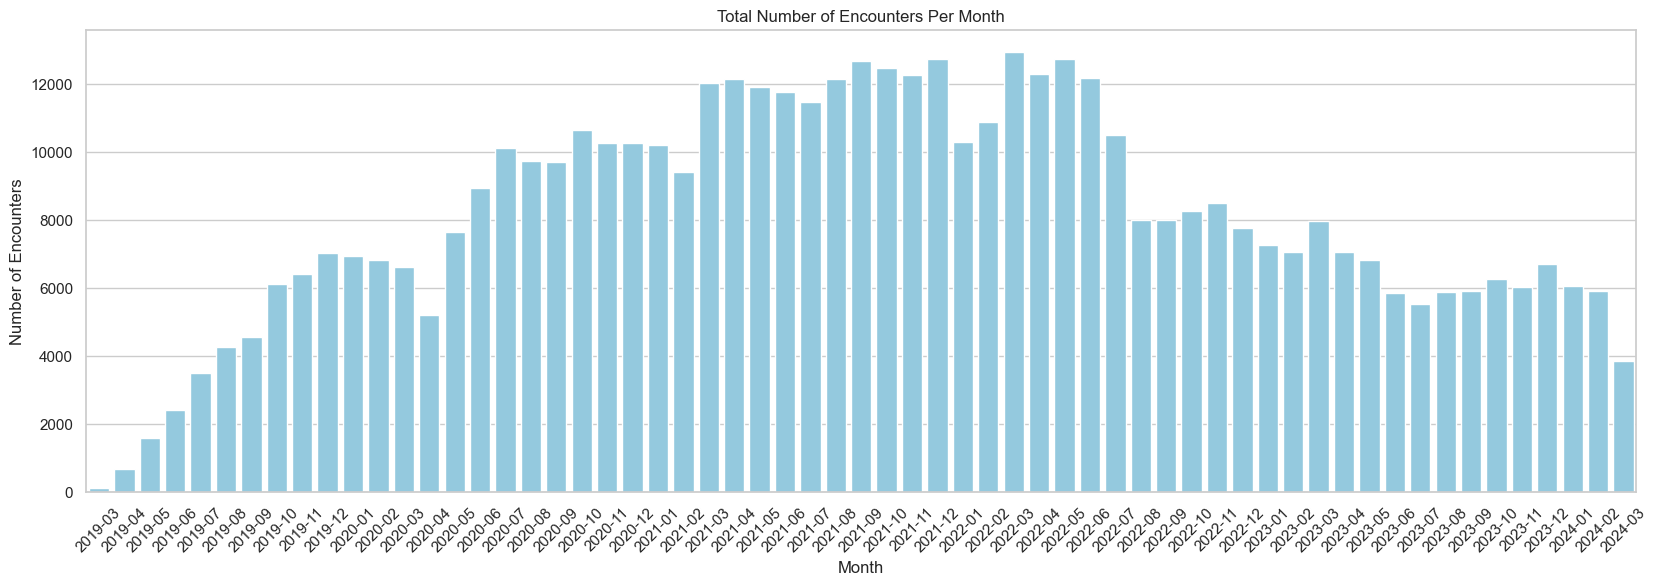

In [108]:
resp_support.loc[:, 'recorded_dttm'] = pd.to_datetime(resp_support['recorded_dttm'])
resp_check = resp_support
resp_check['recorded_date'] = resp_check['recorded_dttm'].dt.date
resp_check['recorded_hour'] = resp_check['recorded_dttm'].dt.hour
# Create a month column
resp_check['month'] = resp_check['recorded_dttm'].dt.to_period('M')

# Count the number of encounters each month
monthly_encounter_counts = resp_check.groupby('month')['encounter_id'].nunique().reset_index()
# Rename columns for clarity
monthly_encounter_counts.columns = ['Month', 'Number of Encounters']

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
sns.barplot(x='Month', y='Number of Encounters', data=monthly_encounter_counts, color='skyblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Number of Encounters')
plt.title('Total Number of Encounters Per Month')

# Show the plot
plt.show()

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/1850566577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resp_check['recorded_date'] = resp_check['recorded_dttm'].dt.date
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/1850566577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resp_check['recorded_hour'] = resp_check['recorded_dttm'].dt.hour
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/1850566577.py:6: SettingWithCopyWarning: 
A value is trying

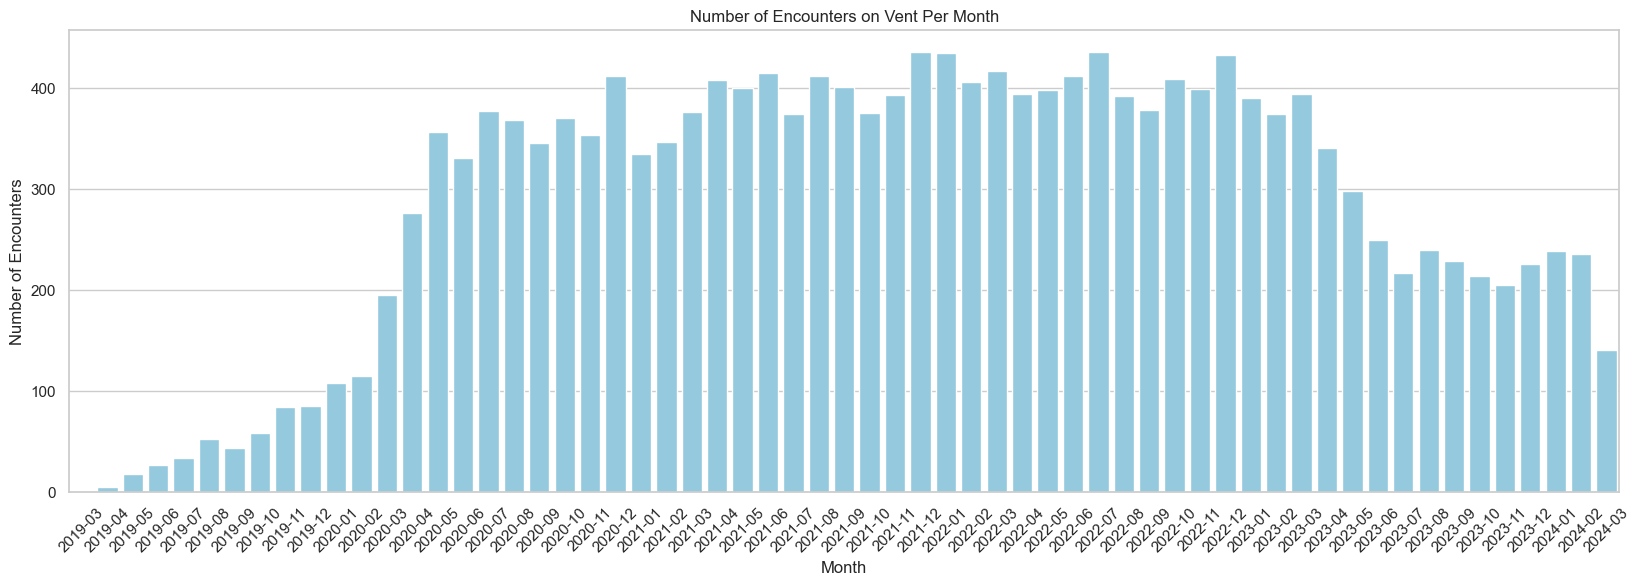

In [109]:
resp_support.loc[:, 'recorded_dttm'] = pd.to_datetime(resp_support['recorded_dttm'])
resp_check = resp_support[resp_support['device_category'].str.contains("Vent", case=False, na=False)]
resp_check['recorded_date'] = resp_check['recorded_dttm'].dt.date
resp_check['recorded_hour'] = resp_check['recorded_dttm'].dt.hour
# Create a month column
resp_check['month'] = resp_check['recorded_dttm'].dt.to_period('M')

# Count the number of encounters each month
monthly_encounter_counts = resp_check.groupby('month')['encounter_id'].nunique().reset_index()
# Rename columns for clarity
monthly_encounter_counts.columns = ['Month', 'Number of Encounters']

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
sns.barplot(x='Month', y='Number of Encounters', data=monthly_encounter_counts, color='skyblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Number of Encounters')
plt.title('Number of Encounters on Vent Per Month')

# Show the plot
plt.show()

## Respiratory support - Hourly

In [110]:
# Function to generate hourly sequence for each group (encounter_id)
def generate_hourly_sequence(group):
    start_time = group['vent_start_time'].iloc[0]
    end_time = group['recorded_dttm'].max()
    
    # Generate the sequence of hourly timestamps
    hourly_timestamps = pd.date_range(start=start_time, end=end_time, freq='h') 
    
    # Create a new DataFrame for this sequence
    return pd.DataFrame({
        'encounter_id': group['encounter_id'].iloc[0],
        'recorded_dttm': hourly_timestamps
    })

# Apply the function to each group and concatenate the results, using include_groups=False
hour_sequence = resp_filtered.groupby('encounter_id').apply(generate_hourly_sequence).reset_index(drop=True)

# Add `recorded_date` and `recorded_hour` columns
# Convert recorded_dttm to datetime if not already done
hour_sequence['recorded_dttm'] = pd.to_datetime(hour_sequence['recorded_dttm'])
hour_sequence['recorded_date'] = hour_sequence['recorded_dttm'].dt.date
hour_sequence['recorded_hour'] = hour_sequence['recorded_dttm'].dt.hour
hour_sequence['time'] = hour_sequence.groupby('encounter_id').cumcount() 

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2229551323.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hour_sequence = resp_filtered.groupby('encounter_id').apply(generate_hourly_sequence).reset_index(drop=True)


In [111]:
hour_sequence

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time
0,10932,2021-12-19 03:05:00,2021-12-19,3,0
1,10932,2021-12-19 04:05:00,2021-12-19,4,1
2,10932,2021-12-19 05:05:00,2021-12-19,5,2
3,10932,2021-12-19 06:05:00,2021-12-19,6,3
4,10932,2021-12-19 07:05:00,2021-12-19,7,4
...,...,...,...,...,...
1650565,29999273,2021-11-27 07:52:00,2021-11-27,7,75
1650566,29999273,2021-11-27 08:52:00,2021-11-27,8,76
1650567,29999273,2021-11-27 09:52:00,2021-11-27,9,77
1650568,29999273,2021-11-27 10:52:00,2021-11-27,10,78


In [112]:
## get first 72 hrs after intubation
first_72_hours = hour_sequence[hour_sequence['time'] < 72]

In [113]:
first_72_hours

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time
0,10932,2021-12-19 03:05:00,2021-12-19,3,0
1,10932,2021-12-19 04:05:00,2021-12-19,4,1
2,10932,2021-12-19 05:05:00,2021-12-19,5,2
3,10932,2021-12-19 06:05:00,2021-12-19,6,3
4,10932,2021-12-19 07:05:00,2021-12-19,7,4
...,...,...,...,...,...
1650557,29999273,2021-11-26 23:52:00,2021-11-26,23,67
1650558,29999273,2021-11-27 00:52:00,2021-11-27,0,68
1650559,29999273,2021-11-27 01:52:00,2021-11-27,1,69
1650560,29999273,2021-11-27 02:52:00,2021-11-27,2,70


In [114]:
resp_cleaned['recorded_dttm'] = pd.to_datetime(resp_cleaned['recorded_dttm'])
resp_cleaned['recorded_date'] = resp_cleaned['recorded_dttm'].dt.date
resp_cleaned['recorded_hour'] = resp_cleaned['recorded_dttm'].dt.hour
hourly_vent_df = resp_cleaned.groupby(['encounter_id', 'recorded_date', 'recorded_hour']).agg(
    min_resp_rate_obs=pd.NamedAgg(column='resp_rate_obs', aggfunc='min'),
    min_lpm_set=pd.NamedAgg(column='lpm_set', aggfunc='min'),
    min_fio2_set=pd.NamedAgg(column='fio2_set', aggfunc='min'),
    min_peep_set=pd.NamedAgg(column='peep_set', aggfunc='min'),
    min_peep_obs=pd.NamedAgg(column='peep_obs', aggfunc='min'),
    max_resp_rate_obs=pd.NamedAgg(column='resp_rate_obs', aggfunc='max'),
    max_lpm_set=pd.NamedAgg(column='lpm_set', aggfunc='max'),
    max_fio2_set=pd.NamedAgg(column='fio2_set', aggfunc='max'),
    max_peep_set=pd.NamedAgg(column='peep_set', aggfunc='max'),
    max_peep_obs=pd.NamedAgg(column='peep_obs', aggfunc='max'),
    hourly_trach=pd.NamedAgg(column='tracheostomy', aggfunc=lambda x: 1 if x.max() == 1 else 0),
    hourly_on_vent=pd.NamedAgg(column='on_vent', aggfunc=lambda x: 1 if x.max() == 1 else 0)
).reset_index()

In [115]:
# Merge hourly_vent_df with hour_sequence on encounter_id, recorded_date, and recorded_hour
merged_df = pd.merge(first_72_hours, hourly_vent_df, on=['encounter_id', 'recorded_date', 'recorded_hour'], how='left')

In [116]:
merged_df

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,min_resp_rate_obs,min_lpm_set,min_fio2_set,min_peep_set,min_peep_obs,max_resp_rate_obs,max_lpm_set,max_fio2_set,max_peep_set,max_peep_obs,hourly_trach,hourly_on_vent
0,10932,2021-12-19 03:05:00,2021-12-19,3,0,22.0,15.0,1.0,5.0,5.0,22.0,15.0,1.0,5.0,5.0,0.0,1.0
1,10932,2021-12-19 04:05:00,2021-12-19,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10932,2021-12-19 05:05:00,2021-12-19,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10932,2021-12-19 06:05:00,2021-12-19,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10932,2021-12-19 07:05:00,2021-12-19,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350716,29999273,2021-11-26 23:52:00,2021-11-26,23,67,20.0,2.0,0.4,NaN,NaN,20.0,2.0,0.4,NaN,NaN,0.0,0.0
350717,29999273,2021-11-27 00:52:00,2021-11-27,0,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350718,29999273,2021-11-27 01:52:00,2021-11-27,1,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350719,29999273,2021-11-27 02:52:00,2021-11-27,2,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exclude:

1. Encounters that were on vent for less than 2 hours
2. Encounters that were on trach in the first 72 hours 

In [117]:
# Calculate the total hours on vent for each encounter within the first 72 hours
vent_hours_per_encounter = merged_df.groupby('encounter_id')['hourly_on_vent'].sum()

# Identify encounters with less than 2 hours on vent
encounters_less_than_2_hours = vent_hours_per_encounter[vent_hours_per_encounter < 2].index

# Exclude those encounters from first_72_hours_df
merged_df = merged_df[~merged_df['encounter_id'].isin(encounters_less_than_2_hours)]

In [118]:
print("unique encounters after excluding encounters on vent for less than 2 hrs", count_unique_encounters(merged_df))

unique encounters after excluding encounters on vent for less than 2 hrs 5578


In [119]:
# Exclude encounters with tracheostomy in the first 72 hours
# Identify encounters with trach in the first 72 hours
encounters_with_trach = merged_df.groupby('encounter_id')['hourly_trach'].max()

# Identify encounters where trach is present
encounters_with_trach = encounters_with_trach[encounters_with_trach == 1].index

# Exclude those encounters from first_72_hours_df
merged_df = merged_df[~merged_df['encounter_id'].isin(encounters_with_trach)]

In [120]:
print("unique encounters after excluding encounters on trach in first 72 hrs", count_unique_encounters(merged_df))

unique encounters after excluding encounters on trach in first 72 hrs 5249


In [121]:
merged_df_cleaned = remove_duplicates(merged_df, ['encounter_id', 'recorded_date', 'recorded_hour'], 'merged_df')

Processing DataFrame: merged_df
No duplicates found based on columns: ['encounter_id', 'recorded_date', 'recorded_hour'].
Number of unique encounters in merged_df: 5249



In [122]:
# Extract unique encounter_ids from merged_df_cleaned
cohort_final = merged_df_cleaned[['encounter_id']].drop_duplicates()

## Vitals - Hourly

#### Step 1: Filter Down to the Encounter IDs in the final cohort

In [123]:
# Filter the vitals DataFrame to include only the encounters in cohort_encounters
vitals_filtered = vitals[vitals['encounter_id'].isin(cohort_final['encounter_id'])].copy()

#### Step 2: Calculate date, hour, year Columns Using the recorded_dttm Column

In [124]:
# Create new columns for hour, date, and year from the recorded_dttm column
vitals_filtered['recorded_dttm'] = pd.to_datetime(vitals_filtered['recorded_dttm'])
vitals_filtered['recorded_hour'] = vitals_filtered['recorded_dttm'].dt.hour
vitals_filtered['recorded_date'] = vitals_filtered['recorded_dttm'].dt.date

#### Step 3: Reshape the Data to Create Min and Max Values for Each Vital for Each Hour for an Encounter

In [125]:
# Define the vital categories of interest
vital_categories = ['sbp', 'dbp', 'map', 'respiratory_rate', 'pulse', 'spo2']

# Filter vitals to only include rows with the relevant vital categories
vitals_filtered = vitals_filtered[vitals_filtered['vital_category'].isin(vital_categories)]

# Group by encounter_id, date, hour, and vital_category, and calculate the min and max values
vitals_min_max = vitals_filtered.groupby(['encounter_id', 'recorded_date', 'recorded_hour', 'vital_category']).agg(
    min=pd.NamedAgg(column='vital_value', aggfunc='min'),
    max=pd.NamedAgg(column='vital_value', aggfunc='max')
).reset_index()

# Pivot the table to reshape it
vitals_pivot = vitals_min_max.pivot_table(
    index=['encounter_id', 'recorded_date', 'recorded_hour'],
    columns='vital_category',
    values=['min', 'max']
).reset_index()

# Flatten the column multi-index after pivot
vitals_pivot.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in vitals_pivot.columns]
# Remove trailing underscores
vitals_pivot.columns = [col.rstrip('_') for col in vitals_pivot.columns]

In [126]:
# Display the result
print(vitals_pivot.columns)

Index(['encounter_id', 'recorded_date', 'recorded_hour', 'max_dbp', 'max_map',
       'max_pulse', 'max_respiratory_rate', 'max_sbp', 'max_spo2', 'min_dbp',
       'min_map', 'min_pulse', 'min_respiratory_rate', 'min_sbp', 'min_spo2'],
      dtype='object')


In [127]:
# merge vitals with the blocked resp support data
main_df = pd.merge(merged_df, vitals_pivot, on=['encounter_id', 'recorded_date', 'recorded_hour'], how='left')

In [128]:
print(main_df.columns)

Index(['encounter_id', 'recorded_dttm', 'recorded_date', 'recorded_hour',
       'time', 'min_resp_rate_obs', 'min_lpm_set', 'min_fio2_set',
       'min_peep_set', 'min_peep_obs', 'max_resp_rate_obs', 'max_lpm_set',
       'max_fio2_set', 'max_peep_set', 'max_peep_obs', 'hourly_trach',
       'hourly_on_vent', 'max_dbp', 'max_map', 'max_pulse',
       'max_respiratory_rate', 'max_sbp', 'max_spo2', 'min_dbp', 'min_map',
       'min_pulse', 'min_respiratory_rate', 'min_sbp', 'min_spo2'],
      dtype='object')


In [129]:
checkpoint_vitals = remove_duplicates(main_df, ['encounter_id', 'recorded_date', 'recorded_hour'], 'main_df')

Processing DataFrame: main_df
No duplicates found based on columns: ['encounter_id', 'recorded_date', 'recorded_hour'].
Number of unique encounters in main_df: 5249



## Labs - Hourly

#### Step 1: Filter Down to the Encounter IDs in the cohort_encounters DataFrame and lab_category == Lactic_acid

In [130]:
# Ensure lab_result_dttm is in datetime format
labs['lab_result_dttm'] = pd.to_datetime(labs['lab_result_dttm'])
# Create new columns for hour, date, and year from the recorded_dttm column
labs['recorded_hour'] = labs['lab_result_dttm'].dt.hour
labs['recorded_date'] = labs['lab_result_dttm'].dt.date

# Filter the vitals DataFrame to include only the encounters in cohort_encounters
labs_filtered = labs[labs['encounter_id'].isin(cohort_final['encounter_id'])].copy()

# Filter for lactate measurements (assuming the lab_name for lactate is "lactic_acid")
lactate_df = labs_filtered[labs_filtered['lab_category'] == 'lactic_acid']

#### Step 2: Get most recent lactate defined as closest lab result time to the start of ventilation

In [131]:
# Ensure lab_result_dttm is in datetime format UPDATE: FILL LACTATE, GET THE LATEST VALUE FOR THAT HOUR
labs['lab_result_dttm'] = pd.to_datetime(labs['lab_result_dttm'])
# Create new columns for hour, date, and year from the recorded_dttm column
labs['recorded_hour'] = labs['lab_result_dttm'].dt.hour
labs['recorded_date'] = labs['lab_result_dttm'].dt.date

# Filter the labs DataFrame to include only the encounters in cohort_final
labs_filtered = labs[labs['encounter_id'].isin(cohort_final['encounter_id'])].copy()

# Filter for lactate measurements
lactate_df = labs_filtered[labs_filtered['lab_category'] == 'lactic_acid']

# Perform a left join of vent_start_end with lactate_df on encounter_id
lactate_df = pd.merge(lactate_df, vent_start_end, on='encounter_id', how='left')

lactate_df['time_since_vent_start_hours'] = (
    (lactate_df['lab_result_dttm'] - lactate_df['vent_start_time']).dt.total_seconds() / 3600
)

# Calculate the absolute time difference between lab_result_dttm and vent_start_time in hours
lactate_df['time_diff_hours'] = abs((lactate_df['lab_result_dttm'] - lactate_df['vent_start_time']).dt.total_seconds() / 3600)

# Filter for observations within the first 72 hours since vent_start_time
lactate_df = lactate_df[(lactate_df['time_since_vent_start_hours'] >= 0) & 
                        (lactate_df['time_since_vent_start_hours'] <= 72)]

# Sort by encounter_id, recorded_hour, and time_diff_hours to find the closest measurement to vent_start_time
lactate_df = lactate_df.sort_values(by=['encounter_id', 'recorded_date', 'recorded_hour', 'time_diff_hours'])

# Group by encounter_id and recorded_hour, and get the first row in each group (which is the closest measurement)
# closest lactate measurement is defined as closest to the vent_start_time in that hour. 
closest_lactate_df = lactate_df.groupby(['encounter_id', 'recorded_date','recorded_hour']).first().reset_index()

In [132]:
# Select the required columns and rename 'lab_value_numeric' to 'lactate'
labs_final = closest_lactate_df[['encounter_id', 'recorded_date', 'recorded_hour', 'lab_value_numeric']].copy()

# Rename the 'lab_value_numeric' column to 'lactate'
labs_final = labs_final.rename(columns={'lab_value_numeric': 'lactate'})

In [133]:
main_df = pd.merge(main_df, labs_final, on=['encounter_id', 'recorded_date', 'recorded_hour'], how='left')

In [134]:
# Sanity check: Display the first few rows
checkpoint_labs = remove_duplicates(main_df, ['encounter_id', 'recorded_date', 'recorded_hour'], 'main_df')

Processing DataFrame: main_df
No duplicates found based on columns: ['encounter_id', 'recorded_date', 'recorded_hour'].
Number of unique encounters in main_df: 5249



In [135]:
main_df

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,min_resp_rate_obs,min_lpm_set,min_fio2_set,min_peep_set,min_peep_obs,...,max_respiratory_rate,max_sbp,max_spo2,min_dbp,min_map,min_pulse,min_respiratory_rate,min_sbp,min_spo2,lactate
0,10932,2021-12-19 03:05:00,2021-12-19,3,0,22.0,15.0,1.0,5.0,5.0,...,13.0,90.0,99.0,45.0,61.0,73.0,13.0,90.0,99.0,4.6
1,10932,2021-12-19 04:05:00,2021-12-19,4,1,NaN,NaN,NaN,NaN,NaN,...,14.0,127.0,100.0,65.0,8.0,73.0,13.0,127.0,99.0,NaN
2,10932,2021-12-19 05:05:00,2021-12-19,5,2,NaN,NaN,NaN,NaN,NaN,...,13.0,132.0,100.0,48.0,61.0,70.0,12.0,71.0,100.0,NaN
3,10932,2021-12-19 06:05:00,2021-12-19,6,3,NaN,NaN,NaN,NaN,NaN,...,22.0,NaN,100.0,NaN,8.0,70.0,13.0,NaN,100.0,NaN
4,10932,2021-12-19 07:05:00,2021-12-19,7,4,NaN,NaN,NaN,NaN,NaN,...,13.0,113.0,100.0,48.0,67.0,76.0,13.0,113.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319749,29999119,2022-01-10 20:30:00,2022-01-10,20,67,17.0,60.0,0.5,5.0,5.1,...,15.0,136.0,91.0,59.0,81.0,99.0,15.0,134.0,91.0,NaN
319750,29999119,2022-01-10 21:30:00,2022-01-10,21,68,20.0,60.0,0.5,5.0,5.6,...,18.0,174.0,92.0,77.0,111.0,107.0,18.0,169.0,92.0,NaN
319751,29999119,2022-01-10 22:30:00,2022-01-10,22,69,20.0,60.0,0.5,5.0,5.6,...,18.0,166.0,92.0,72.0,10.0,113.0,18.0,163.0,90.0,NaN
319752,29999119,2022-01-10 23:30:00,2022-01-10,23,70,20.0,60.0,0.5,5.0,5.6,...,16.0,164.0,91.0,73.0,103.0,113.0,16.0,151.0,91.0,NaN


## Continuous Meds - Hourly

In [136]:
## filter to encounters in the cohort
meds_filtered = meds[meds['encounter_id'].isin(cohort_final['encounter_id'])].copy()
# Convert 'med_dose' from string to float
meds_filtered['med_dose'] = pd.to_numeric(meds_filtered['med_dose'], errors='coerce')
# Convert 'admin_dttm' to datetime format
meds_filtered['admin_dttm'] = pd.to_datetime(meds_filtered['admin_dttm'], format='%Y-%m-%d %H:%M:%S')
# Create 'date' and 'hour_of_day' columns
meds_filtered['recorded_date'] = meds_filtered['admin_dttm'].dt.date
meds_filtered['recorded_hour'] = meds_filtered['admin_dttm'].dt.hour

#### Norepinephrine calculations

In [137]:
# List of medication names to filter by
meds_list = [
    "norepinephrine", "epinephrine", "phenylephrine", 
    "vasopressin", "dopamine",  
    "angiotensin"
]

# Filter meds for records where med_name is in meds_list
ne_df = meds_filtered[meds_filtered['med_name'].isin(meds_list)].copy()

In [138]:
# Pivot the DataFrame to aggregate min and max doses by medication and hour
pivoted_med_df = ne_df.pivot_table(
    index=['encounter_id', 'recorded_date', 'recorded_hour'],
    columns='med_name',
    values='med_dose',
    aggfunc=['min', 'max']
).reset_index()

# Flatten the MultiIndex columns
pivoted_med_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted_med_df.columns]
# Remove trailing underscores
pivoted_med_df.columns = [col.rstrip('_') for col in pivoted_med_df.columns]

In [139]:
# Calculate the NE dose using the available minimum columns
pivoted_med_df['ne_calc_min'] = (
    pivoted_med_df['min_norepinephrine'].fillna(0) +
    pivoted_med_df['min_epinephrine'].fillna(0) +
    pivoted_med_df['min_phenylephrine'].fillna(0) / 10 +
    pivoted_med_df['min_dopamine'].fillna(0) / 100 +
    pivoted_med_df['min_vasopressin'].fillna(0) * 2.5 +
    pivoted_med_df['min_angiotensin'].fillna(0) * 10
)

# Calculate the NE dose using the available maximum columns
pivoted_med_df['ne_calc_max'] = (
    pivoted_med_df['max_norepinephrine'].fillna(0) +
    pivoted_med_df['max_epinephrine'].fillna(0) +
    pivoted_med_df['max_phenylephrine'].fillna(0) / 10 +
    pivoted_med_df['max_dopamine'].fillna(0) / 100 +
    pivoted_med_df['max_vasopressin'].fillna(0) * 2.5 +
    pivoted_med_df['max_angiotensin'].fillna(0) * 10
)

# Select the relevant columns
ne_calc_df = pivoted_med_df[[
    'encounter_id', 'recorded_date', 'recorded_hour',
    'min_norepinephrine', 'max_norepinephrine',
    'ne_calc_min', 'ne_calc_max'
]].drop_duplicates(subset=['encounter_id', 'recorded_date', 'recorded_hour'])

In [140]:
main_df = pd.merge(main_df, ne_calc_df, on=['encounter_id', 'recorded_date', 'recorded_hour'], how='left')

In [141]:
checkpoint_meds1 = remove_duplicates(main_df, ['encounter_id', 'recorded_date', 'recorded_hour'], 'main_df')

Processing DataFrame: main_df
No duplicates found based on columns: ['encounter_id', 'recorded_date', 'recorded_hour'].
Number of unique encounters in main_df: 5249



In [142]:
main_df

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,min_resp_rate_obs,min_lpm_set,min_fio2_set,min_peep_set,min_peep_obs,...,min_map,min_pulse,min_respiratory_rate,min_sbp,min_spo2,lactate,min_norepinephrine,max_norepinephrine,ne_calc_min,ne_calc_max
0,10932,2021-12-19 03:05:00,2021-12-19,3,0,22.0,15.0,1.0,5.0,5.0,...,61.0,73.0,13.0,90.0,99.0,4.6,NaN,NaN,0.10,0.10
1,10932,2021-12-19 04:05:00,2021-12-19,4,1,NaN,NaN,NaN,NaN,NaN,...,8.0,73.0,13.0,127.0,99.0,NaN,NaN,NaN,0.05,0.05
2,10932,2021-12-19 05:05:00,2021-12-19,5,2,NaN,NaN,NaN,NaN,NaN,...,61.0,70.0,12.0,71.0,100.0,NaN,NaN,NaN,0.00,0.00
3,10932,2021-12-19 06:05:00,2021-12-19,6,3,NaN,NaN,NaN,NaN,NaN,...,8.0,70.0,13.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN
4,10932,2021-12-19 07:05:00,2021-12-19,7,4,NaN,NaN,NaN,NaN,NaN,...,67.0,76.0,13.0,113.0,100.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319749,29999119,2022-01-10 20:30:00,2022-01-10,20,67,17.0,60.0,0.5,5.0,5.1,...,81.0,99.0,15.0,134.0,91.0,NaN,NaN,NaN,NaN,NaN
319750,29999119,2022-01-10 21:30:00,2022-01-10,21,68,20.0,60.0,0.5,5.0,5.6,...,111.0,107.0,18.0,169.0,92.0,NaN,NaN,NaN,NaN,NaN
319751,29999119,2022-01-10 22:30:00,2022-01-10,22,69,20.0,60.0,0.5,5.0,5.6,...,10.0,113.0,18.0,163.0,90.0,NaN,NaN,NaN,NaN,NaN
319752,29999119,2022-01-10 23:30:00,2022-01-10,23,70,20.0,60.0,0.5,5.0,5.6,...,103.0,113.0,16.0,151.0,91.0,NaN,NaN,NaN,NaN,NaN


#### Red criteria Med flags

In [143]:
red_meds_list = [
    "nicardipine", "nitroprusside", "clevidipine"
]

In [144]:
# Filter meds_filtered for the medications in red_meds_list
red_meds_df = meds_filtered[meds_filtered['med_name'].isin(red_meds_list)].copy()

# Create a flag for each medication in red_meds_list
for med in red_meds_list:
    # Create a flag that is 1 if the medication was administered in that hour, 0 otherwise
    red_meds_df[med + '_flag'] = np.where(red_meds_df['med_name'] == med, 1, 0).astype(int)

# Aggregate to get the maximum value for each flag (per encounter_id, recorded_date, recorded_hour)
# This ensures that if the medication was administered even once in the hour, the flag is 1
red_meds_flags = red_meds_df.groupby(['encounter_id', 'recorded_date', 'recorded_hour']).agg(
    {med + '_flag': 'max' for med in red_meds_list}
).reset_index()

#  combine all flags into a single 'red_meds_flag', you can do so like this:
red_meds_flags['red_meds_flag'] = red_meds_flags[[med + '_flag' for med in red_meds_list]].max(axis=1)

# Select the relevant columns
red_meds_flags_final = red_meds_flags[[
    'encounter_id', 'recorded_date', 'recorded_hour',
    'nicardipine_flag', 'nitroprusside_flag',
    'clevidipine_flag', 'red_meds_flag'
]].drop_duplicates(subset=['encounter_id', 'recorded_date', 'recorded_hour'])

In [145]:
## combine with main_df
main_df = pd.merge(main_df, red_meds_flags_final, on=['encounter_id', 'recorded_date', 'recorded_hour'], how='left')

In [146]:
# Cast the specified columns to integers, ignoring NaNs
main_df['nicardipine_flag'] = pd.to_numeric(main_df['nicardipine_flag'], errors='coerce').fillna(0).astype(int)
main_df['nitroprusside_flag'] = pd.to_numeric(main_df['nitroprusside_flag'], errors='coerce').fillna(0).astype(int)
main_df['clevidipine_flag'] = pd.to_numeric(main_df['clevidipine_flag'], errors='coerce').fillna(0).astype(int)
main_df['red_meds_flag'] = pd.to_numeric(main_df['red_meds_flag'], errors='coerce').fillna(0).astype(int)


In [147]:
checkpoint_meds2 = remove_duplicates(main_df, ['encounter_id', 'recorded_date', 'recorded_hour'], 'main_df')

Processing DataFrame: main_df
No duplicates found based on columns: ['encounter_id', 'recorded_date', 'recorded_hour'].
Number of unique encounters in main_df: 5249



In [148]:
print(red_meds_flags_final.dtypes)

encounter_id            int32
recorded_date          object
recorded_hour         float64
nicardipine_flag        int64
nitroprusside_flag      int64
clevidipine_flag        int64
red_meds_flag           int64
dtype: object


In [149]:
print(main_df.dtypes)

encounter_id                     int32
recorded_dttm           datetime64[ns]
recorded_date                   object
recorded_hour                    int32
time                             int64
min_resp_rate_obs              float64
min_lpm_set                    float64
min_fio2_set                   float64
min_peep_set                   float64
min_peep_obs                   float64
max_resp_rate_obs              float64
max_lpm_set                    float64
max_fio2_set                   float64
max_peep_set                   float64
max_peep_obs                   float64
hourly_trach                   float64
hourly_on_vent                 float64
max_dbp                        float64
max_map                        float64
max_pulse                      float64
max_respiratory_rate           float64
max_sbp                        float64
max_spo2                       float64
min_dbp                        float64
min_map                        float64
min_pulse                

## Forward fill by encounter_id 

In [150]:
# List of columns to forward and backward fill
columns_to_fill = [
    'min_resp_rate_obs', 'min_lpm_set', 'min_fio2_set', 'min_peep_set', 'min_peep_obs',
    'max_resp_rate_obs', 'max_lpm_set', 'max_fio2_set', 'max_peep_set', 'max_peep_obs',
    'hourly_trach', 'hourly_on_vent', 'max_dbp', 'max_map', 'max_pulse',
    'max_respiratory_rate', 'max_sbp', 'max_spo2', 'min_dbp', 'min_map', 'min_pulse',
    'min_respiratory_rate', 'min_sbp', 'min_spo2', 'lactate',
    'min_norepinephrine', 'max_norepinephrine', 'ne_calc_min', 'ne_calc_max',
    'nicardipine_flag', 'nitroprusside_flag', 'clevidipine_flag', 'red_meds_flag'
]

In [151]:
# Forward and backward fill (down-up) for each encounter_id
main_df[columns_to_fill] = main_df.groupby('encounter_id')[columns_to_fill].transform(lambda x: x.ffill().bfill())

## Filter for business hours

In [152]:
# Business hours are from 8 AM (inclusive) to 5 PM (exclusive), so hours 8 to 16 are included
business_hours_df = main_df[(main_df['recorded_hour'] >= 8) & (main_df['recorded_hour'] < 17)]
business_hours_df['time_biz'] = business_hours_df.groupby('encounter_id').cumcount() 

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/1018226726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_hours_df['time_biz'] = business_hours_df.groupby('encounter_id').cumcount()


In [153]:
business_hours_df.dtypes

encounter_id                     int32
recorded_dttm           datetime64[ns]
recorded_date                   object
recorded_hour                    int32
time                             int64
min_resp_rate_obs              float64
min_lpm_set                    float64
min_fio2_set                   float64
min_peep_set                   float64
min_peep_obs                   float64
max_resp_rate_obs              float64
max_lpm_set                    float64
max_fio2_set                   float64
max_peep_set                   float64
max_peep_obs                   float64
hourly_trach                   float64
hourly_on_vent                 float64
max_dbp                        float64
max_map                        float64
max_pulse                      float64
max_respiratory_rate           float64
max_sbp                        float64
max_spo2                       float64
min_dbp                        float64
min_map                        float64
min_pulse                

## Analysis

In [250]:
#  Create a copy of business_hours_df
final_df = business_hours_df.copy()

### Patel et al. Criteria:

* Mean arterial blood pressure: 65-110 mm Hg
* Systolic blood pressure: ≤ 200 mm Hg
* Heart rate: 40-130 beats per minute
* Respiratory rate: 5-40 breaths per minute
* Pulse oximetry: ≥ 88%

In [251]:
# Apply Patel et al. Criteria

# 1. Mean arterial blood pressure: 65-110 mm Hg
final_df['patel_map_flag'] = (
    (final_df['min_map'] >= 65) & (final_df['max_map'] <= 110)
).astype(int)

# 2. Systolic blood pressure: ≤ 200 mm Hg
final_df['patel_sbp_flag'] = (
    final_df['max_sbp'] <= 200
).astype(int)

# 3. Heart rate (Pulse): 40-130 beats per minute
final_df['patel_pulse_flag'] = (
    (final_df['min_pulse'] >= 40) & (final_df['max_pulse'] <= 130)
).astype(int)

# 4. Respiratory rate: 5-40 breaths per minute
final_df['patel_resp_rate_flag'] = (
    (final_df['min_respiratory_rate'] >= 5) & (final_df['max_respiratory_rate'] <= 40)
).astype(int)

# 5. Pulse oximetry (SpO2): ≥ 88%
final_df['patel_spo2_flag'] = (
    final_df['min_spo2'] >= 88
).astype(int)

# Step 2: Create the overall Patel flag
final_df['patel_flag'] = (
    final_df['patel_map_flag'] &
    final_df['patel_sbp_flag'] &
    final_df['patel_pulse_flag'] &
    final_df['patel_resp_rate_flag'] &
    final_df['patel_spo2_flag']
)

In [156]:
final_df

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,min_resp_rate_obs,min_lpm_set,min_fio2_set,min_peep_set,min_peep_obs,...,nitroprusside_flag,clevidipine_flag,red_meds_flag,time_biz,patel_map_flag,patel_sbp_flag,patel_pulse_flag,patel_resp_rate_flag,patel_spo2_flag,patel_flag
5,10932,2021-12-19 08:05:00,2021-12-19,8,5,22.0,15.0,0.35,5.0,5.0,...,0,0,0,0,0,1,1,1,1,0
6,10932,2021-12-19 09:05:00,2021-12-19,9,6,22.0,15.0,0.35,5.0,5.0,...,0,0,0,1,0,1,1,1,1,0
7,10932,2021-12-19 10:05:00,2021-12-19,10,7,13.0,15.0,0.35,5.0,5.0,...,0,0,0,2,0,1,1,1,1,0
8,10932,2021-12-19 11:05:00,2021-12-19,11,8,13.0,15.0,0.35,5.0,5.0,...,0,0,0,3,0,1,1,1,1,0
9,10932,2021-12-19 12:05:00,2021-12-19,12,9,13.0,15.0,0.35,5.0,4.9,...,0,0,0,4,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319741,29999119,2022-01-10 12:30:00,2022-01-10,12,59,18.0,60.0,0.40,5.0,5.1,...,0,0,0,22,0,1,1,1,1,0
319742,29999119,2022-01-10 13:30:00,2022-01-10,13,60,18.0,60.0,0.40,5.0,5.1,...,0,0,0,23,0,1,1,1,1,0
319743,29999119,2022-01-10 14:30:00,2022-01-10,14,61,18.0,60.0,0.40,5.0,5.1,...,0,0,0,24,0,1,1,1,1,0
319744,29999119,2022-01-10 15:30:00,2022-01-10,15,62,18.0,60.0,0.40,5.0,5.1,...,0,0,0,25,0,1,1,1,1,0


### TEAM criteria

* Heart rate: ≤ 150 bpm
* Most recent lactate: ≤ 4.0 mmol/L
* Noradrenaline infusion rate: 0.1-0.2 mcg/kg/min (inclusive)- I used calculated NE for this. 
* Sufficient respiratory stability:
    *  FiO2: ≤ 0.6
    *  PEEP: ≤ 16 cm H2O (use peep_observed)
* Current respiratory rate: ≤ 45 (use resp_rate_obs)

In [252]:
# 1. Heart rate: ≤ 150 bpm
final_df['team_pulse_flag'] = (
    final_df['max_pulse'] <= 150
).astype(int)

# 2. Most recent lactate: ≤ 4.0 mmol/L
final_df['team_lactate_flag'] = (
    final_df['lactate'] <= 4.0
).astype(int)

# 3. Noradrenaline infusion rate: 0.1-0.2 mcg/kg/min
final_df['team_ne_flag'] = (
    # (final_df['ne_calc_min'] >= 0.1) & (final_df['ne_calc_max'] <= 0.2)
    final_df['ne_calc_max'] <= 0.2
).astype(int)

# 4. Sufficient respiratory stability:
#    a. FiO2: ≤ 0.6
final_df['team_fio2_flag'] = (
    final_df['min_fio2_set'] <= 0.6
).astype(int)

#    b. PEEP: ≤ 16 cm H2O
final_df['team_peep_flag'] = (
    final_df['max_peep_set'] <= 16
).astype(int)

# 5. Current respiratory rate: ≤ 45
final_df['team_resp_rate_flag'] = (
    final_df['max_resp_rate_obs'] <= 45
).astype(int)

# Step 2: Create the overall TEAM flag
final_df['team_flag'] = (
    final_df['team_pulse_flag'] &
    final_df['team_lactate_flag'] &
    final_df['team_ne_flag'] &
    final_df['team_fio2_flag'] &
    final_df['team_peep_flag'] &
    final_df['team_resp_rate_flag']
)

In [246]:
columns_to_view = [
    'encounter_id', 'recorded_dttm', 'recorded_date', 'recorded_hour', 'time',
    'team_peep_flag', 'max_peep_set', 'max_peep_obs', 'min_peep_set', 'min_peep_obs','team_peep_flag']
subset_df = final_df[columns_to_view]

In [247]:
subset_df


,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,team_peep_flag,max_peep_set,max_peep_obs,min_peep_set,min_peep_obs,team_peep_flag
5,10932,2021-12-19 08:05:00,2021-12-19,8,5,1,5.0,5.0,5.0,5.0,1
6,10932,2021-12-19 09:05:00,2021-12-19,9,6,1,5.0,5.0,5.0,5.0,1
7,10932,2021-12-19 10:05:00,2021-12-19,10,7,1,5.0,5.0,5.0,5.0,1
8,10932,2021-12-19 11:05:00,2021-12-19,11,8,1,5.0,5.0,5.0,5.0,1
9,10932,2021-12-19 12:05:00,2021-12-19,12,9,1,5.0,5.0,5.0,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...
319741,29999119,2022-01-10 12:30:00,2022-01-10,12,59,1,5.0,5.1,5.0,5.1,1
319742,29999119,2022-01-10 13:30:00,2022-01-10,13,60,1,5.0,5.1,5.0,5.1,1
319743,29999119,2022-01-10 14:30:00,2022-01-10,14,61,1,5.0,5.1,5.0,5.1,1
319744,29999119,2022-01-10 15:30:00,2022-01-10,15,62,1,5.0,5.1,5.0,5.1,1


### Consensus criteria

* Green Criteria
    * Respiratory
        * Saturation  90% and
        * Respiratory rate ≤ 30 breaths/min
        * Current FiO2 ≤ 0.6 and
        * PEEP≤ 10cm H20
    * Cardiovascular:
        * Blood pressure greater than lower limit of target range (MAP 65+) while on no or low level of support (low support- define as <0.1 μg/kg/min of Norepi equivalents)
        * Heart rate <120 beats/min
        * lactate < 4mmol/L
        * HR > 40
* Yellow Criteria
    * Respiratory
        * Sat >= 90%
        * Current FiO2 >0.6
        * Respiratory rate >30breaths/min
        * PEEP >10cm H20
    * Cardiovascular
        * Blood pressure greater than lower limit of target range (MAP 65+) while receiving moderate level of support (medium-define as 0.1–0.3 μg/kg/min of Norepi equivalents)
        * Heart rate 120-150 beats/min
        * Shock of any cause with lactate >4mmol/L
        * HR > 40
* Red Criteria
    * Respiratory
        * Sat <90%
    * Cardiovascular
        * Below target MAP despite support (MAP <65) or
        * greater than lower limit MAP (MAP 65+) but on high level support (high defined as >0.3 μg/kg/min of Norepi equivalents)
        * IV therapy for hypertensive emergency (SBP >200mmHg or MAP >110 and on nicardipine, nitroprusside, or clevidipine gtt)
        * HR >150 bpm
        * Bradycardia <40

In [160]:
# # Step 1: Implement Green Criteria

# # Green Respiratory Criteria
# final_df['green_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
# final_df['green_resp_rate_flag'] = (final_df['max_resp_rate_obs'] <= 30).astype(int)
# final_df['green_fio2_flag'] = (final_df['min_fio2_set'] <= 0.6).astype(int)
# final_df['green_peep_flag'] = (final_df['max_peep_obs'] <= 10).astype(int)

# # Green Cardiovascular Criteria
# final_df['green_map_flag'] = (final_df['min_map'] >= 65).astype(int)
# final_df['green_ne_flag'] = (final_df['ne_calc_max'] < 0.1).astype(int)
# final_df['green_pulse_flag'] = (final_df['max_pulse'] < 120).astype(int)

# final_df['green_flag'] = (
#     final_df['green_resp_spo2_flag'] &
#     final_df['green_resp_rate_flag'] &
#     final_df['green_fio2_flag'] &
#     final_df['green_peep_flag'] &
#     final_df['green_map_flag'] &
#     final_df['green_ne_flag'] &
#     final_df['green_pulse_flag']
# ).astype(int)

# # Step 2: Implement Yellow Criteria

# # Yellow Respiratory Criteria
# final_df['yellow_fio2_flag'] = (final_df['min_fio2_set'] > 0.6).astype(int)
# final_df['yellow_resp_rate_flag'] = (final_df['max_resp_rate_obs'] > 30).astype(int)
# final_df['yellow_peep_flag'] = (final_df['max_peep_obs'] > 10).astype(int)

# # Yellow Cardiovascular Criteria
# final_df['yellow_map_flag'] = (final_df['min_map'] >= 65).astype(int)
# final_df['yellow_ne_flag'] = (
#     (final_df['ne_calc_min'] >= 0.1) & (final_df['ne_calc_max'] <= 0.3)
# ).astype(int)
# final_df['yellow_pulse_flag'] = (
#     (final_df['min_pulse'] >= 120) & (final_df['max_pulse'] <= 150)
# ).astype(int)
# final_df['yellow_lactate_flag'] = (final_df['lactate'] > 4).astype(int)

# final_df['yellow_flag'] = (
#     final_df['yellow_fio2_flag'] &
#     final_df['yellow_resp_rate_flag'] &
#     final_df['yellow_peep_flag'] &
#     final_df['yellow_map_flag'] &
#     final_df['yellow_ne_flag'] &
#     final_df['yellow_pulse_flag'] &
#     final_df['yellow_lactate_flag']
# ).astype(int)

# # Step 3: Implement Red Criteria

# # Red Respiratory Criteria
# final_df['red_resp_spo2_flag'] = (final_df['min_spo2'] < 90).astype(int)

# # Red Cardiovascular Criteria
# final_df['red_map_flag'] = (final_df['min_map'] < 65).astype(int)
# final_df['red_high_support_flag'] = (final_df['ne_calc_max'] > 0.3).astype(int)
# final_df['red_hypertensive_flag'] = (
#     ((final_df['max_sbp'] > 200) | (final_df['max_map'] > 110)) &
#     (final_df['nicardipine_flag'] | final_df['nitroprusside_flag'] | final_df['clevidipine_flag'])
# ).astype(int)
# final_df['red_pulse_high_flag'] = (final_df['max_pulse'] > 150).astype(int)
# final_df['red_pulse_low_flag'] = (final_df['min_pulse'] < 40).astype(int)

# final_df['red_flag'] = (
#     final_df['red_resp_spo2_flag'] &
#     final_df['red_map_flag'] &
#     final_df['red_high_support_flag'] &
#     final_df['red_hypertensive_flag'] &
#     final_df['red_pulse_high_flag'] &
#     final_df['red_pulse_low_flag']
# ).astype(int)

In [161]:
# # Red Respiratory Criteria
# final_df['red_resp_spo2_flag'] = (final_df['min_spo2'] < 90).astype(int)

# # Red Cardiovascular Criteria
# final_df['red_map_flag'] = (final_df['min_map'] < 65).astype(int)

# # High support (Norepinephrine equivalents > 0.3 μg/kg/min)
# final_df['red_high_support_flag'] = (final_df['ne_calc_max'] > 0.3).astype(int)

# # Hypertensive emergency criteria (SBP > 200 mmHg or MAP > 110 mmHg and on certain medications)
# final_df['red_hypertensive_flag'] = (
#     ((final_df['max_sbp'] > 200) | (final_df['max_map'] > 110)) &
#     (final_df['nicardipine_flag'] | final_df['nitroprusside_flag'] | final_df['clevidipine_flag'])
# ).astype(int)

# # High heart rate criteria (HR > 150 bpm)
# final_df['red_pulse_high_flag'] = (final_df['max_pulse'] > 150).astype(int)

# # Low heart rate criteria (HR < 40 bpm)
# final_df['red_pulse_low_flag'] = (final_df['min_pulse'] < 40).astype(int)

# # Combine all Red Criteria flags into a single red_flag
# final_df['red_flag'] = (
#     final_df['red_resp_spo2_flag'] |
#     final_df['red_map_flag'] |
#     final_df['red_high_support_flag'] |
#     final_df['red_hypertensive_flag'] |
#     final_df['red_pulse_high_flag'] |
#     final_df['red_pulse_low_flag']
# ).astype(int)

# # Implement Green Criteria

# # Green Respiratory Criteria
# final_df['green_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
# final_df['green_resp_rate_flag'] = (final_df['max_resp_rate_obs'] <= 30).astype(int)
# final_df['green_fio2_flag'] = (final_df['min_fio2_set'] <= 0.6).astype(int)
# final_df['green_peep_flag'] = (final_df['min_peep_set'] <= 10).astype(int)

# # Green Cardiovascular Criteria
# final_df['green_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'] < 0.1).astype(int)
# final_df['green_ne_flag'] = (final_df['ne_calc_max'] < 0.1).astype(int)
# final_df['green_pulse_flag'] = (final_df['min_pulse'] < 120).astype(int)
# final_df['green_lactate_flag'] = (final_df['lactate'] < 4).astype(int)
# final_df['green_hr_flag'] = (final_df['min_pulse'] > 40).astype(int)

# # Combine all Green Criteria flags into a single green_flag, but exclude those already meeting red  criteria
# final_df['green_flag'] = (
#     (
#         final_df['green_resp_spo2_flag'] &
#         final_df['green_resp_rate_flag'] &
#         final_df['green_fio2_flag'] &
#         final_df['green_peep_flag'] &
#         final_df['green_map_flag'] &
#         final_df['green_ne_flag']  &
#         final_df['green_pulse_flag'] &
#         final_df['green_lactate_flag'] &
#         final_df['green_hr_flag']
#     ) &
#     (final_df['red_flag'] == 0) 
# ).astype(int)

# #  Implement Yellow Criteria
# ## ANY YELLOW OR ANY GREEN BUT NOT ALL GREEN

# # Yellow Respiratory Criteria
# final_df['yellow_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
# final_df['yellow_fio2_flag'] = (final_df['min_fio2_set'] > 0.6).astype(int)
# final_df['yellow_resp_rate_flag'] = (final_df['max_resp_rate_obs'] > 30).astype(int)
# final_df['yellow_peep_flag'] = (final_df['min_peep_set'] > 10).astype(int)

# # Yellow Cardiovascular Criteria
# final_df['yellow_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'].between(0.1, 0.3)).astype(int)
# final_df['yellow_pulse_flag'] = (final_df['min_pulse'].between(120, 150)).astype(int)
# final_df['yellow_lactate_flag'] = (final_df['lactate'] > 4).astype(int)

# # Combine all Yellow Criteria flags into a single yellow_flag, but exclude those already meeting red criteria
# # any yellow or green satisfies the yellow criteria
# final_df['yellow_flag'] = (
#     (
#         final_df['yellow_resp_spo2_flag']|  # OR logic for yellow criteria
#         final_df['yellow_fio2_flag']     |
#         final_df['yellow_resp_rate_flag']|
#         final_df['yellow_peep_flag']     |
#         final_df['yellow_map_flag']      |
#         final_df['yellow_pulse_flag']    |
#         final_df['yellow_lactate_flag']  |
#         final_df['green_resp_spo2_flag'] |
#         final_df['green_resp_rate_flag'] |
#         final_df['green_fio2_flag']      |
#         final_df['green_peep_flag']      |
#         final_df['green_map_flag']       |
#         final_df['green_ne_flag']        |
#         final_df['green_pulse_flag']     |
#         final_df['green_lactate_flag']   |
#         final_df['green_hr_flag']
#     ) &
#     (final_df['red_flag'] == 0) & # Ensure no red criteria are met
#     (final_df['green_flag'] == 0) 
# ).astype(int)

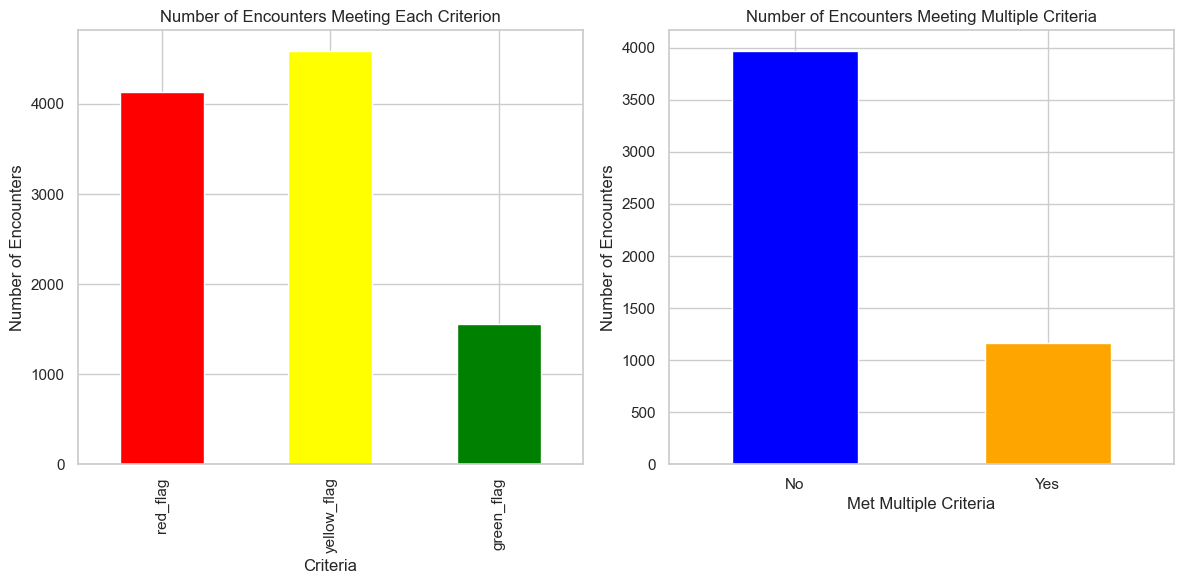

In [163]:
# ## consensus criteria check

# # Create a DataFrame to store the counts of criteria met
# criteria_counts = final_df[['encounter_id', 'red_flag', 'yellow_flag', 'green_flag']].groupby('encounter_id').max()

# # Plot the histograms
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# criteria_counts[['red_flag', 'yellow_flag', 'green_flag']].sum().plot(kind='bar', color=['red', 'yellow', 'green'])
# plt.title('Number of Encounters Meeting Each Criterion')
# plt.xlabel('Criteria')
# plt.ylabel('Number of Encounters')

# # Step 2: Check if any encounter met more than one criterion

# # Add columns to check for overlaps
# criteria_counts['multiple_flags'] = (criteria_counts[['red_flag', 'yellow_flag', 'green_flag']].sum(axis=1) > 1).astype(int)

# # Histogram of encounters meeting more than one criterion
# plt.subplot(1, 2, 2)
# criteria_counts['multiple_flags'].value_counts().plot(kind='bar', color=['blue', 'orange'])
# plt.title('Number of Encounters Meeting Multiple Criteria')
# plt.xlabel('Met Multiple Criteria')
# plt.ylabel('Number of Encounters')
# plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

# plt.tight_layout()
# plt.show()

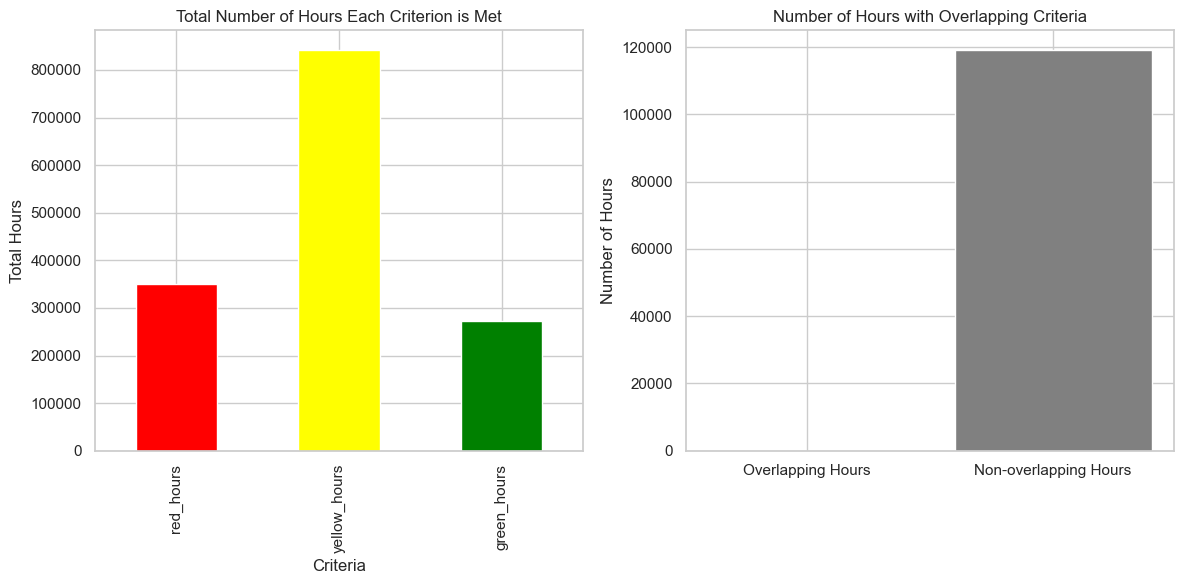

In [164]:
# # Create a DataFrame to store the sum of hours for each criterion
# hours_criteria_df = final_df[['time_biz', 'red_flag', 'yellow_flag', 'green_flag']].copy()

# # Multiply each flag by the time_biz to get the total hours each criterion is met
# hours_criteria_df['red_hours'] = hours_criteria_df['red_flag'] * hours_criteria_df['time_biz']
# hours_criteria_df['yellow_hours'] = hours_criteria_df['yellow_flag'] * hours_criteria_df['time_biz']
# hours_criteria_df['green_hours'] = hours_criteria_df['green_flag'] * hours_criteria_df['time_biz']

# # Sum the hours across all encounters
# total_hours = hours_criteria_df[['red_hours', 'yellow_hours', 'green_hours']].sum()

# # Step 2: Check for overlaps in criteria met within the same hour

# # Create a column to check if more than one criterion is met in the same hour
# hours_criteria_df['multiple_criteria_met'] = (
#     hours_criteria_df[['red_flag', 'yellow_flag', 'green_flag']].sum(axis=1) > 1
# ).astype(int)

# # Sum the total hours where more than one criterion is met
# overlap_hours = hours_criteria_df['multiple_criteria_met'].sum()

# # Plot the results

# plt.figure(figsize=(12, 6))

# # Plot the total number of hours each criterion is met
# plt.subplot(1, 2, 1)
# total_hours.plot(kind='bar', color=['red', 'yellow', 'green'])
# plt.title('Total Number of Hours Each Criterion is Met')
# plt.xlabel('Criteria')
# plt.ylabel('Total Hours')

# # Plot the number of hours where more than one criterion is met
# plt.subplot(1, 2, 2)
# plt.bar(['Overlapping Hours', 'Non-overlapping Hours'], [overlap_hours, len(hours_criteria_df) - overlap_hours], color=['purple', 'gray'])
# plt.title('Number of Hours with Overlapping Criteria')
# plt.ylabel('Number of Hours')

# plt.tight_layout()
# plt.show()

In [165]:
# final_df

,encounter_id,recorded_dttm,recorded_date,recorded_hour,time,min_resp_rate_obs,min_lpm_set,min_fio2_set,min_peep_set,min_peep_obs,...,green_hr_flag,green_flag,yellow_resp_spo2_flag,yellow_fio2_flag,yellow_resp_rate_flag,yellow_peep_flag,yellow_map_flag,yellow_pulse_flag,yellow_lactate_flag,yellow_flag
5,10932,2021-12-19 08:05:00,2021-12-19,8,5,22.0,15.0,0.35,5.0,5.0,...,1,0,1,0,0,0,0,0,1,0
6,10932,2021-12-19 09:05:00,2021-12-19,9,6,22.0,15.0,0.35,5.0,5.0,...,1,0,1,0,0,0,0,0,1,0
7,10932,2021-12-19 10:05:00,2021-12-19,10,7,13.0,15.0,0.35,5.0,5.0,...,1,0,1,0,0,0,0,0,1,0
8,10932,2021-12-19 11:05:00,2021-12-19,11,8,13.0,15.0,0.35,5.0,5.0,...,1,0,1,0,0,0,0,0,1,0
9,10932,2021-12-19 12:05:00,2021-12-19,12,9,13.0,15.0,0.35,5.0,4.9,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319741,29999119,2022-01-10 12:30:00,2022-01-10,12,59,18.0,60.0,0.40,5.0,5.1,...,1,0,1,0,0,0,0,0,0,1
319742,29999119,2022-01-10 13:30:00,2022-01-10,13,60,18.0,60.0,0.40,5.0,5.1,...,1,0,1,0,0,0,0,0,0,1
319743,29999119,2022-01-10 14:30:00,2022-01-10,14,61,18.0,60.0,0.40,5.0,5.1,...,1,0,1,0,0,0,0,0,0,0
319744,29999119,2022-01-10 15:30:00,2022-01-10,15,62,18.0,60.0,0.40,5.0,5.1,...,1,0,1,0,0,0,0,0,0,1


In [166]:
# final_df.columns.tolist()

['encounter_id',
 'recorded_dttm',
 'recorded_date',
 'recorded_hour',
 'time',
 'min_resp_rate_obs',
 'min_lpm_set',
 'min_fio2_set',
 'min_peep_set',
 'min_peep_obs',
 'max_resp_rate_obs',
 'max_lpm_set',
 'max_fio2_set',
 'max_peep_set',
 'max_peep_obs',
 'hourly_trach',
 'hourly_on_vent',
 'max_dbp',
 'max_map',
 'max_pulse',
 'max_respiratory_rate',
 'max_sbp',
 'max_spo2',
 'min_dbp',
 'min_map',
 'min_pulse',
 'min_respiratory_rate',
 'min_sbp',
 'min_spo2',
 'lactate',
 'min_norepinephrine',
 'max_norepinephrine',
 'ne_calc_min',
 'ne_calc_max',
 'nicardipine_flag',
 'nitroprusside_flag',
 'clevidipine_flag',
 'red_meds_flag',
 'time_biz',
 'patel_map_flag',
 'patel_sbp_flag',
 'patel_pulse_flag',
 'patel_resp_rate_flag',
 'patel_spo2_flag',
 'patel_flag',
 'team_pulse_flag',
 'team_lactate_flag',
 'team_ne_flag',
 'team_fio2_flag',
 'team_peep_flag',
 'team_resp_rate_flag',
 'team_flag',
 'red_resp_spo2_flag',
 'red_map_flag',
 'red_high_support_flag',
 'red_hypertensive_flag'

### Consensus criteria - redefined 

* all_red: All red subcomponents must be met.
* all_green: All green subcomponents must be met, and no red subcomponents are met.
* all_yellow: All yellow subcomponents must be met, no red subcomponents are met, and all green subcomponents are not met.
* any_yellow: Any yellow subcomponent is met, no green subcomponents are fully met, and no red subcomponents are met.
* any_yellow_or_green: Any yellow or green subcomponents are met, but no red subcomponents are met.

In [253]:
# Red Cardiovascular Criteria
final_df['red_resp_spo2_flag'] = (final_df['min_spo2'] < 90).astype(int)
final_df['red_map_flag'] = (final_df['min_map'] < 65).astype(int)
# High support (Norepinephrine equivalents > 0.3 μg/kg/min)
final_df['red_high_support_flag'] = (final_df['ne_calc_max'] > 0.3).astype(int)
# Hypertensive emergency criteria (SBP > 200 mmHg or MAP > 110 mmHg and on certain medications)
final_df['red_hypertensive_flag'] = (
    ((final_df['max_sbp'] > 200) | (final_df['max_map'] > 110)) &
    (final_df['nicardipine_flag'] | final_df['nitroprusside_flag'] | final_df['clevidipine_flag'])
).astype(int)
# High heart rate criteria (HR > 150 bpm)
final_df['red_pulse_high_flag'] = (final_df['max_pulse'] > 150).astype(int)
# Low heart rate criteria (HR < 40 bpm)
final_df['red_pulse_low_flag'] = (final_df['min_pulse'] < 40).astype(int)

# Yellow Respiratory Criteria
final_df['yellow_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['yellow_fio2_flag'] = (final_df['min_fio2_set'] > 0.6).astype(int)
final_df['yellow_resp_rate_flag'] = (final_df['max_resp_rate_obs'] > 30).astype(int)
final_df['yellow_peep_flag'] = (final_df['min_peep_set'] > 10).astype(int)

# Yellow Cardiovascular Criteria
final_df['yellow_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'].between(0.1, 0.3)).astype(int)
final_df['yellow_pulse_flag'] = (final_df['min_pulse'].between(120, 150)).astype(int)
final_df['yellow_lactate_flag'] = (final_df['lactate'] > 4).astype(int)

# Step 3: Implement Green Criteria
final_df['green_resp_spo2_flag'] = (final_df['min_spo2'] >= 90).astype(int)
final_df['green_resp_rate_flag'] = (final_df['max_resp_rate_obs'] <= 30).astype(int)
final_df['green_fio2_flag'] = (final_df['min_fio2_set'] <= 0.6).astype(int)
final_df['green_peep_flag'] = (final_df['min_peep_set'] <= 10).astype(int)

# Green Cardiovascular Criteria
final_df['green_map_flag'] = (final_df['min_map'] >= 65).astype(int) & (final_df['ne_calc_max'] < 0.1).astype(int)
final_df['green_pulse_flag'] = (final_df['min_pulse'] < 120).astype(int)
final_df['green_lactate_flag'] = (final_df['lactate'] < 4).astype(int)
final_df['green_hr_flag'] = (final_df['min_pulse'] > 40).astype(int)

In [254]:
# Step 1: Define 'all_red'
final_df['any_red'] = (
    final_df['red_resp_spo2_flag'] |
    final_df['red_map_flag'] |
    final_df['red_high_support_flag'] |
    final_df['red_hypertensive_flag'] |
    final_df['red_pulse_high_flag'] |
    final_df['red_pulse_low_flag']
).astype(int)

final_df['any_yellow'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag']
    )
).astype(int)

final_df['any_green'] = (
    final_df['green_resp_spo2_flag'] |
    final_df['green_resp_rate_flag'] |
    final_df['green_fio2_flag'] |
    final_df['green_peep_flag'] |
    final_df['green_map_flag'] |
    final_df['green_pulse_flag'] |
    final_df['green_lactate_flag'] |
    final_df['green_hr_flag'] 
).astype(int)


final_df['all_green'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] 
).astype(int)

final_df['all_green_no_red'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0)  # Ensure no red subcomponents are met
).astype(int)

final_df['all_green_no_red_yellow'] = (
    final_df['green_resp_spo2_flag'] &
    final_df['green_resp_rate_flag'] &
    final_df['green_fio2_flag'] &
    final_df['green_peep_flag'] &
    final_df['green_map_flag'] &
    final_df['green_pulse_flag'] &
    final_df['green_lactate_flag'] &
    final_df['green_hr_flag'] &
    (final_df['any_red'] == 0)  & # Ensure no red subcomponents are met
    (final_df['any_yellow'] == 0)  # Ensure no yellow subcomponents are met
).astype(int)


# Step 3: Define 'all_yellow_only' (all yellow subcomponents must be met, no red subcomponents, and no green subcomponents)
final_df['all_yellow_no_red_green'] = (
    final_df['yellow_resp_spo2_flag'] &
    final_df['yellow_fio2_flag'] &
    final_df['yellow_resp_rate_flag'] &
    final_df['yellow_peep_flag'] &
    final_df['yellow_map_flag'] &
    final_df['yellow_pulse_flag'] &
    final_df['yellow_lactate_flag'] &
    (final_df['any_red'] == 0) &  # Ensure no red subcomponents are met
    (final_df['any_green'] == 0)  # Ensure no green subcomponents are fully met
).astype(int)

# Step 4: Define 'any_yellow_only' (any yellow subcomponent is met, no green or red subcomponents are met)
final_df['any_yellow_no_red_green'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag']
    ) &
    (final_df['any_red'] == 0) &  # Ensure no red subcomponents are met
    (final_df['any_green'] == 0)  # Ensure no green subcomponents are fully met
).astype(int)

# Step 5: Define 'any_yellow_or_green' (any yellow or green subcomponent is met, but no red subcomponents are met)
final_df['any_yellow_or_green_no_red'] = (
    (
        final_df['yellow_resp_spo2_flag'] |
        final_df['yellow_fio2_flag'] |
        final_df['yellow_resp_rate_flag'] |
        final_df['yellow_peep_flag'] |
        final_df['yellow_map_flag'] |
        final_df['yellow_pulse_flag'] |
        final_df['yellow_lactate_flag'] |
        final_df['green_resp_spo2_flag'] |
        final_df['green_resp_rate_flag'] |
        final_df['green_fio2_flag'] |
        final_df['green_peep_flag'] |
        final_df['green_map_flag'] |
        final_df['green_pulse_flag'] |
        final_df['green_lactate_flag'] |
        final_df['green_hr_flag']
    ) &
    (final_df['any_red'] == 0)  # Ensure no red subcomponents are met
).astype(int)


In [255]:
# Optional: To summarize the results, you can print value counts for each flag
print(final_df[['any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red' ]].sum())

any_red                        31953
any_yellow                    116997
any_green                     119028
all_green                      19009
all_green_no_red               18953
all_green_no_red_yellow            0
all_yellow_no_red_green            0
any_yellow_no_red_green            0
any_yellow_or_green_no_red     87076
dtype: int64


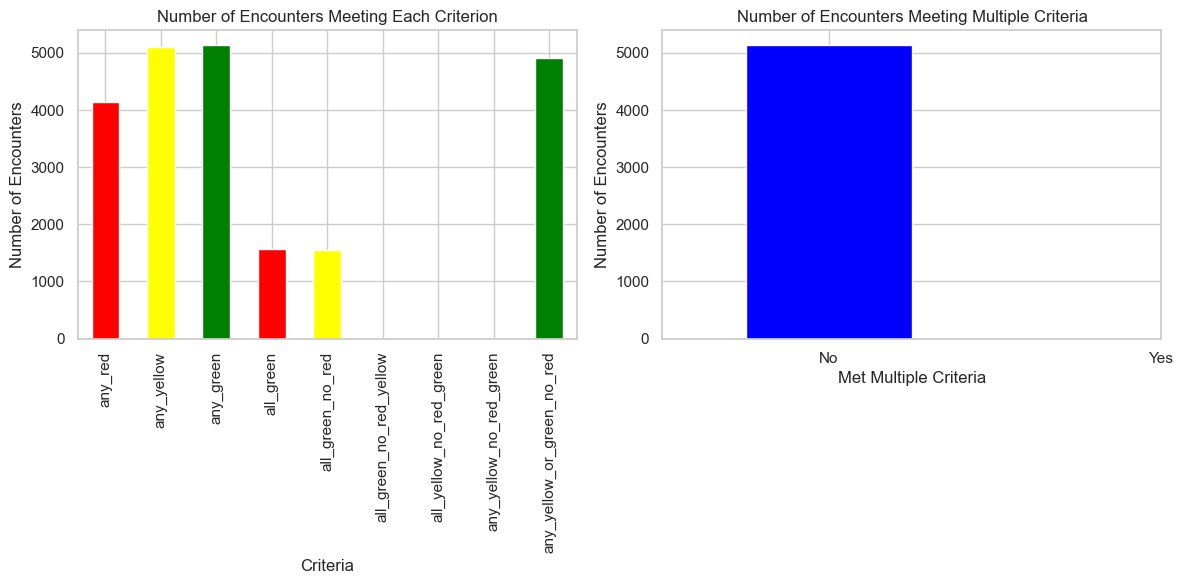

In [256]:
## consensus criteria check

# Create a DataFrame to store the counts of criteria met
criteria_counts = final_df[['encounter_id', 'any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red']].groupby('encounter_id').max()

# Plot the histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
criteria_counts[['any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red']].sum().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Number of Encounters Meeting Each Criterion')
plt.xlabel('Criteria')
plt.ylabel('Number of Encounters')

# Step 2: Check if any encounter met more than one criterion

# Add columns to check for overlaps
criteria_counts['multiple_flags'] = (criteria_counts[['any_red', 'any_yellow', 'any_green' ,  'all_green',
                'all_green_no_red', 'all_green_no_red_yellow', 'all_yellow_no_red_green', 
                'any_yellow_no_red_green','any_yellow_or_green_no_red']].sum(axis=1) > 1).astype(int)

# Histogram of encounters meeting more than one criterion
plt.subplot(1, 2, 2)
criteria_counts['multiple_flags'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Encounters Meeting Multiple Criteria')
plt.xlabel('Met Multiple Criteria')
plt.ylabel('Number of Encounters')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

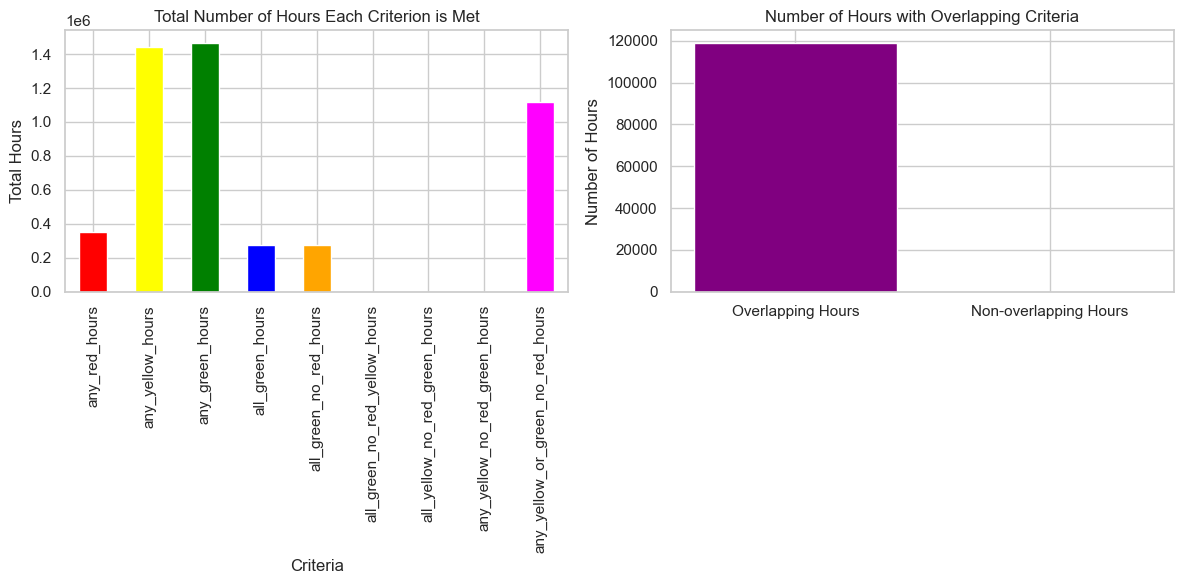

In [257]:
# Step 1: Create a DataFrame to store the sum of hours for each criterion
hours_criteria_df = final_df[['time_biz', 'any_red', 'any_yellow', 'any_green', 'all_green',
                              'all_green_no_red', 'all_green_no_red_yellow', 
                              'all_yellow_no_red_green', 'any_yellow_no_red_green', 
                              'any_yellow_or_green_no_red']].copy()

# Step 2: Multiply each flag by the time_biz to get the total hours each criterion is met
hours_criteria_df['any_red_hours'] = hours_criteria_df['any_red'] * hours_criteria_df['time_biz']
hours_criteria_df['any_yellow_hours'] = hours_criteria_df['any_yellow'] * hours_criteria_df['time_biz']
hours_criteria_df['any_green_hours'] = hours_criteria_df['any_green'] * hours_criteria_df['time_biz']
hours_criteria_df['all_green_hours'] = hours_criteria_df['all_green'] * hours_criteria_df['time_biz']
hours_criteria_df['all_green_no_red_hours'] = hours_criteria_df['all_green_no_red'] * hours_criteria_df['time_biz']
hours_criteria_df['all_green_no_red_yellow_hours'] = hours_criteria_df['all_green_no_red_yellow'] * hours_criteria_df['time_biz']
hours_criteria_df['all_yellow_no_red_green_hours'] = hours_criteria_df['all_yellow_no_red_green'] * hours_criteria_df['time_biz']
hours_criteria_df['any_yellow_no_red_green_hours'] = hours_criteria_df['any_yellow_no_red_green'] * hours_criteria_df['time_biz']
hours_criteria_df['any_yellow_or_green_no_red_hours'] = hours_criteria_df['any_yellow_or_green_no_red'] * hours_criteria_df['time_biz']

# Step 3: Sum the hours across all encounters for each criterion
total_hours = hours_criteria_df[['any_red_hours', 'any_yellow_hours', 'any_green_hours', 'all_green_hours', 
                                 'all_green_no_red_hours', 'all_green_no_red_yellow_hours', 
                                 'all_yellow_no_red_green_hours', 'any_yellow_no_red_green_hours', 
                                 'any_yellow_or_green_no_red_hours']].sum()

# Step 4: Check for overlaps in criteria met within the same hour
# Create a column to check if more than one criterion is met in the same hour
hours_criteria_df['multiple_criteria_met'] = (
    hours_criteria_df[['any_red', 'any_yellow', 'any_green']].sum(axis=1) > 1
).astype(int)

# Sum the total hours where more than one criterion is met
overlap_hours = hours_criteria_df['multiple_criteria_met'].sum()

# Step 5: Plot the results
plt.figure(figsize=(12, 6))

# Plot the total number of hours each criterion is met
plt.subplot(1, 2, 1)
total_hours.plot(kind='bar', color=['red', 'yellow', 'green', 'blue', 'orange', 'purple', 'cyan', 'lime', 'magenta'])
plt.title('Total Number of Hours Each Criterion is Met')
plt.xlabel('Criteria')
plt.ylabel('Total Hours')

# Plot the number of hours where more than one criterion is met
plt.subplot(1, 2, 2)
plt.bar(['Overlapping Hours', 'Non-overlapping Hours'], [overlap_hours, len(hours_criteria_df) - overlap_hours], color=['purple', 'gray'])
plt.title('Number of Hours with Overlapping Criteria')
plt.ylabel('Number of Hours')

plt.tight_layout()
plt.show()


## Summary and Visualizations

In [259]:
# List of columns to keep for visualizations
columns_to_keep = [
    'encounter_id',
    'recorded_date',
    'recorded_hour',
    'time',
    'time_biz',
    'patel_map_flag',
    'patel_sbp_flag',
    'patel_pulse_flag',
    'patel_resp_rate_flag',
    'patel_spo2_flag',
    'patel_flag',
    'team_pulse_flag',
    'team_lactate_flag',
    'team_ne_flag',
    'team_fio2_flag',
    'team_peep_flag',
    'team_resp_rate_flag',
    'team_flag',
    'red_resp_spo2_flag',
    'red_map_flag',
    'red_high_support_flag',
    'red_hypertensive_flag',
    'red_pulse_high_flag',
    'red_pulse_low_flag',
    'yellow_resp_spo2_flag',
    'yellow_fio2_flag',
    'yellow_resp_rate_flag',
    'yellow_peep_flag',
    'yellow_map_flag',
    'yellow_pulse_flag',
    'yellow_lactate_flag',
    'green_resp_spo2_flag',
    'green_resp_rate_flag',
    'green_fio2_flag',
    'green_peep_flag',
    'green_map_flag',
    # 'green_ne_flag',
    'green_pulse_flag',
    'green_lactate_flag',
    'green_hr_flag',
    'any_red',
    'any_yellow',
    'any_green',
    'all_green',
    'all_green_no_red',
    'all_green_no_red_yellow',
    'all_yellow_no_red_green',
    'any_yellow_no_red_green',
    'any_yellow_or_green_no_red'
]

# Create a new DataFrame with only the specified columns
visualization_df = final_df[columns_to_keep]

In [168]:
visualization_df

,encounter_id,recorded_date,recorded_hour,time,time_biz,patel_map_flag,patel_sbp_flag,patel_pulse_flag,patel_resp_rate_flag,patel_spo2_flag,...,green_resp_spo2_flag,green_resp_rate_flag,green_fio2_flag,green_peep_flag,green_map_flag,green_ne_flag,green_pulse_flag,green_lactate_flag,green_hr_flag,green_flag
5,10932,2021-12-19,8,5,0,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
6,10932,2021-12-19,9,6,1,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
7,10932,2021-12-19,10,7,2,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
8,10932,2021-12-19,11,8,3,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
9,10932,2021-12-19,12,9,4,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319741,29999119,2022-01-10,12,59,22,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319742,29999119,2022-01-10,13,60,23,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319743,29999119,2022-01-10,14,61,24,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319744,29999119,2022-01-10,15,62,25,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0


### Criteria met over business hours

In [260]:
encounters_with_27_values = visualization_df.groupby('encounter_id').filter(lambda x: len(x) >= 27)

In [261]:
def plot_criteria_heatmap(df, num_encounters, criteria_flag):
    """
    Plots a heatmap showing when a certain criteria is met over business hours for a subset of encounters.

    Parameters:
    df (DataFrame): The input DataFrame containing the criteria flags and business hour data.
    num_encounters (int): The number of encounters to include in the heatmap.
    criteria_flag (str): The column name of the criteria flag to visualize (e.g., 'patel_flag', 'team_flag', 'green_flag').

    Returns:
    None
    """
    
    # Pivot the DataFrame to create a matrix where rows are encounter IDs and columns are business hours
    matrix = df.pivot(index='encounter_id', columns='time_biz', values=criteria_flag)
    
    # Subset the matrix to include only the specified number of encounters
    subset_matrix = matrix.iloc[:num_encounters, :]
    
    # Replace NaN values with a specific color code if needed, otherwise just leave as NaN
    # subset_matrix = subset_matrix.fillna(-1)
    
    # Set up the color map (red for criteria not met, green for criteria met)
    cmap = sns.color_palette([ "red", "green"])

    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(subset_matrix, cmap=cmap, cbar=False, linewidths=0.5)

    # Add labels and title
    plt.xlabel('Business Hours')
    plt.ylabel('Encounters')  # Simplified y-axis label
    plt.title(f'{criteria_flag.capitalize()} Met Over Business Hours')
    plt.yticks([], [])  # This removes the y-axis labels (encounter IDs)
    plt.show()

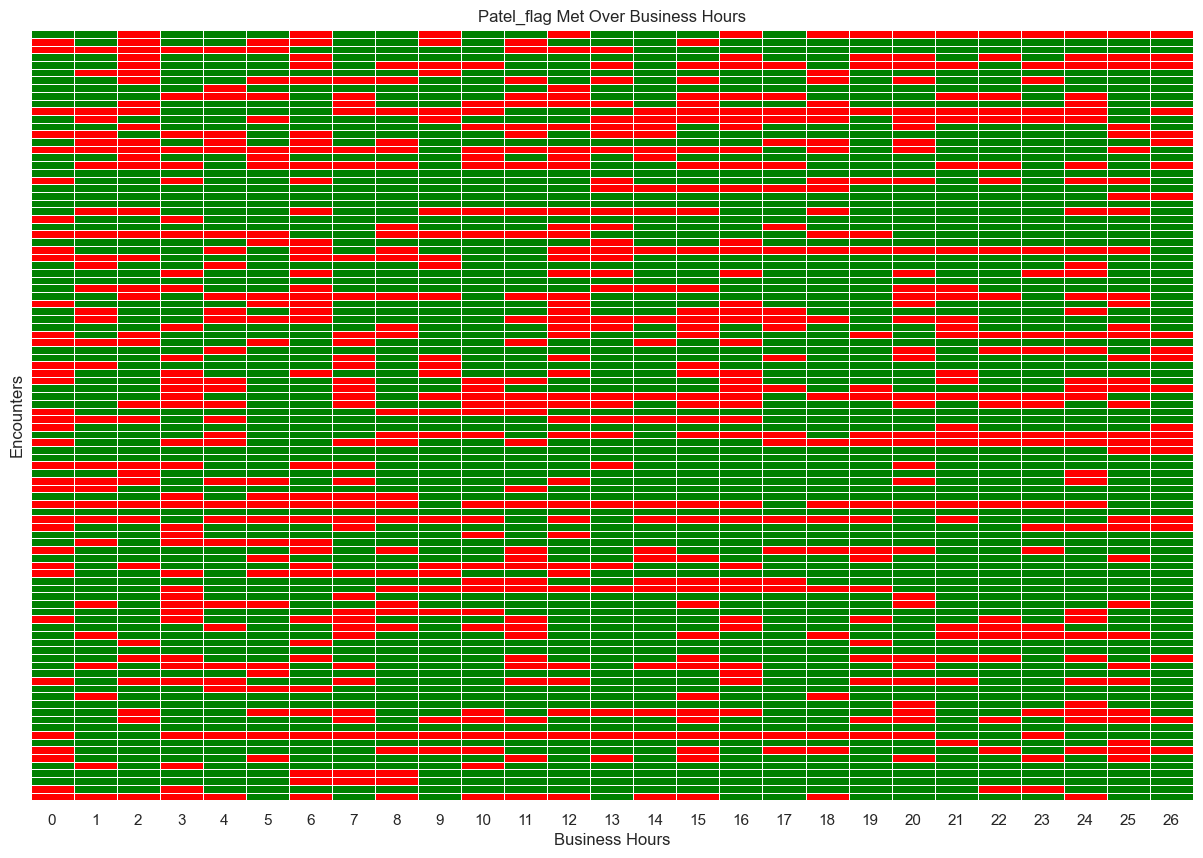

In [171]:
plot_criteria_heatmap(encounters_with_27_values, 100, 'patel_flag')

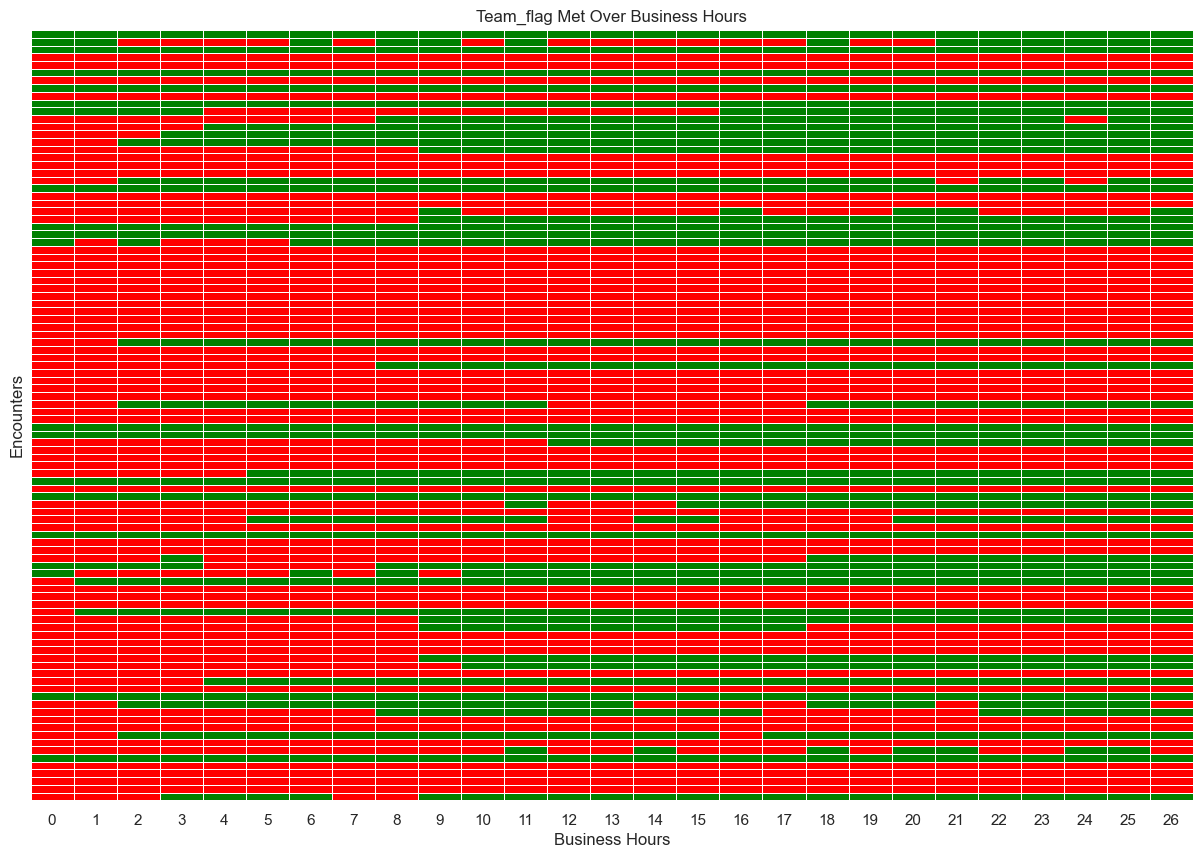

In [262]:
plot_criteria_heatmap(encounters_with_27_values, 100, 'team_flag')

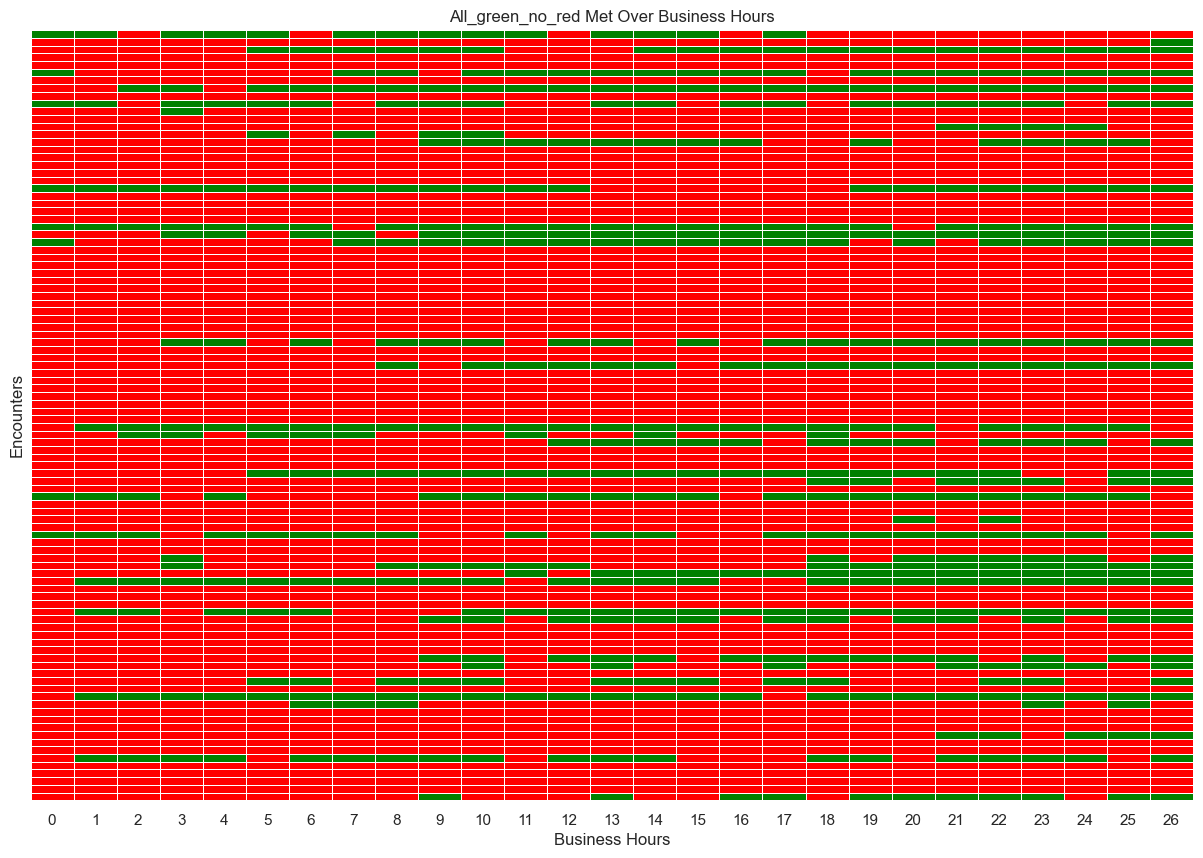

In [263]:
plot_criteria_heatmap(encounters_with_27_values, 100, 'all_green_no_red')

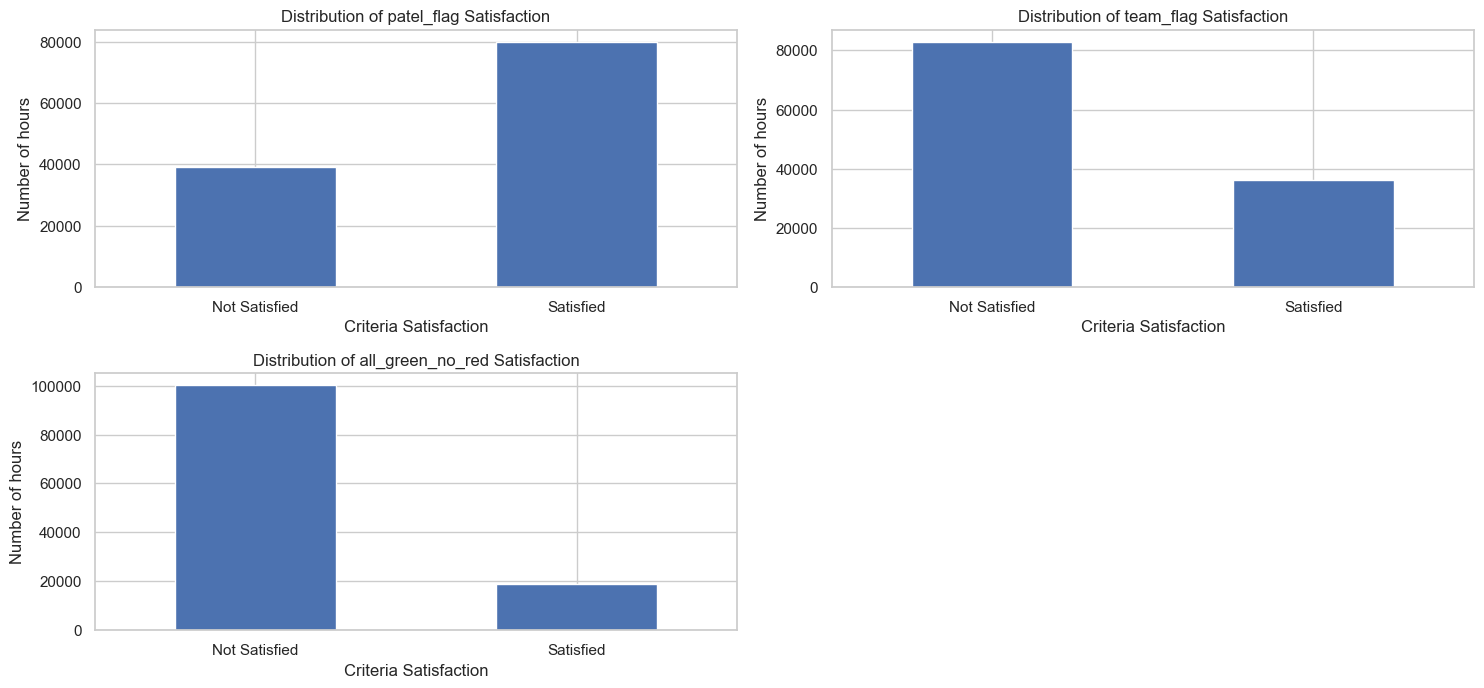

In [265]:
def plot_criteria_histograms(df):
    criteria_flags = ['patel_flag', 'team_flag', 'all_green_no_red']

    plt.figure(figsize=(15, 10))

    for i, flag in enumerate(criteria_flags, 1):
        plt.subplot(3, 2, i)
        
        # Use sort_index() to ensure 0 is first and 1 is second
        df[flag].value_counts().sort_index().plot(kind='bar')
        
        plt.title(f'Distribution of {flag} Satisfaction')
        plt.xticks(rotation=0)
        plt.xlabel('Criteria Satisfaction')
        plt.ylabel('Number of hours')
        plt.xticks([0, 1], ['Not Satisfied', 'Satisfied'])  # Label the bars for clarity
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_criteria_histograms(visualization_df)

### Total number of encounters meeting each criterion.

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/3292076828.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Criteria', y='Number of Encounters', data=criteria_comparison_table, palette='viridis')


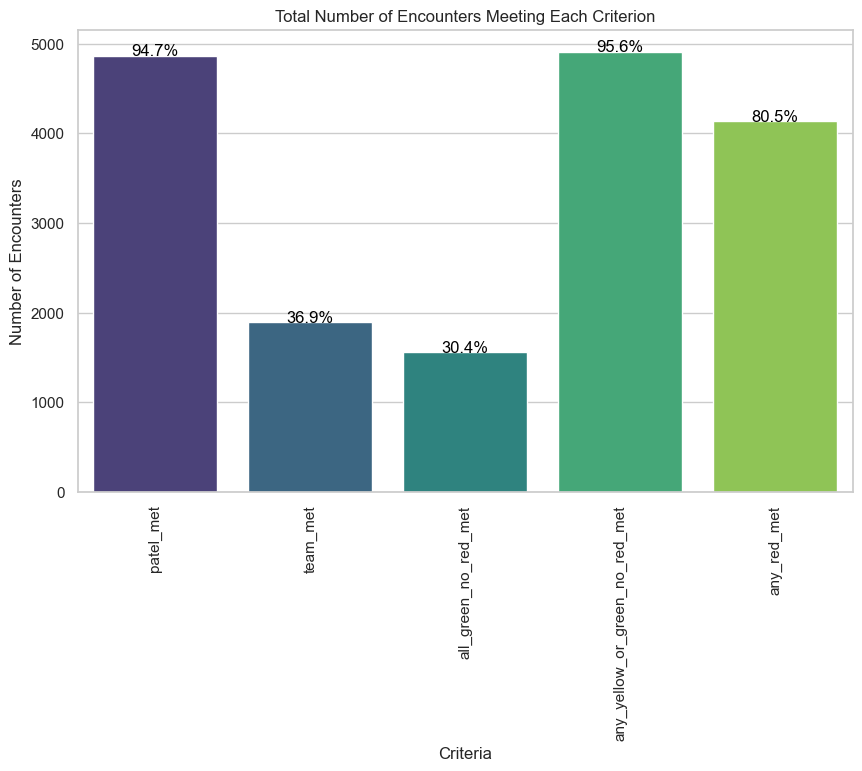

In [272]:
def count_encounters_meeting_criteria(df):
    total_encounters = df['encounter_id'].nunique()  # Calculate total unique encounters
    # For each encounter, check if they ever met the criteria and sum up
    criteria_counts = df.groupby('encounter_id').agg(
        patel_met=('patel_flag', lambda x: x.max()),
        team_met=('team_flag', lambda x: x.max()),
        all_green_no_red_met=('all_green_no_red', lambda x: x.max()),
        any_yellow_or_green_no_red_met=('any_yellow_or_green_no_red', lambda x: x.max()),
        any_red_met=('any_red', lambda x: x.max())
    ).sum().reset_index()

    criteria_counts.columns = ['Criteria', 'Number of Encounters']
    criteria_counts['Percentage'] = (criteria_counts['Number of Encounters'] / total_encounters) * 100
    
    return criteria_counts

# Generate the criteria comparison table
criteria_comparison_table = count_encounters_meeting_criteria(visualization_df)

# Plot the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Criteria', y='Number of Encounters', data=criteria_comparison_table, palette='viridis')
# Rotate the x-axis labels
plt.xticks(rotation=90)
# Add percentages on top of the bars
for index, row in criteria_comparison_table.iterrows():
    barplot.text(index, row['Number of Encounters'] + 0.5, f"{row['Percentage']:.1f}%", 
                 color='black', ha="center")

# Add labels and title
plt.xlabel('Criteria')
plt.ylabel('Number of Encounters')
plt.title('Total Number of Encounters Meeting Each Criterion')

plt.show()

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/1883884974.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Criteria', y='Number of Encounters', data=criteria_comparison_table, palette='viridis')


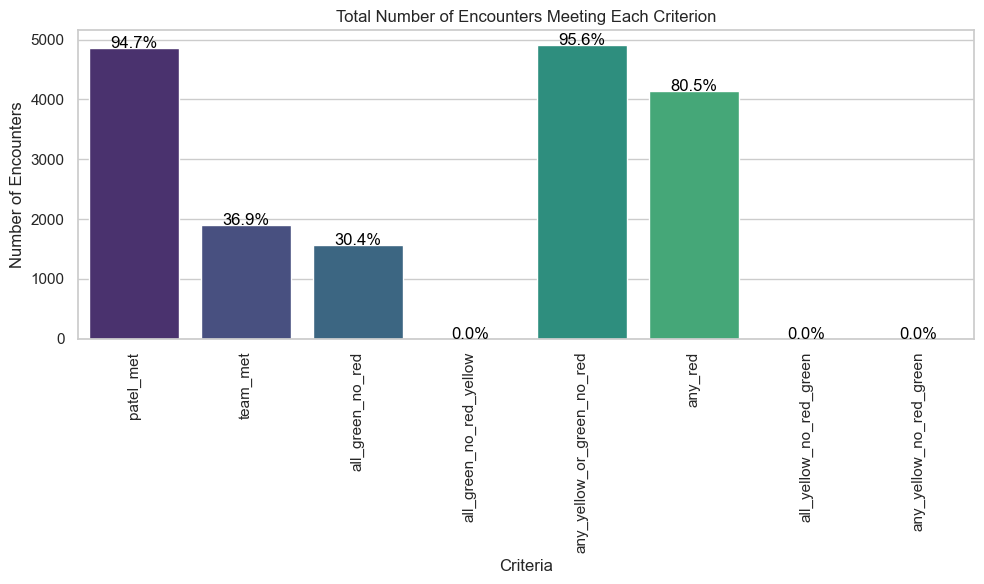

In [273]:
def count_encounters_meeting_criteria(df):
    total_encounters = df['encounter_id'].nunique()  # Calculate total unique encounters
    
    # For each encounter, check if they ever met the criteria and sum up
    criteria_counts = df.groupby('encounter_id').agg(
        patel_met=('patel_flag', lambda x: x.max()),
        team_met=('team_flag', lambda x: x.max()),
        all_green_no_red=('all_green_no_red', lambda x: x.max()),
        all_green_no_red_yellow = ('all_green_no_red_yellow', lambda x: x.max()),
        any_yellow_or_green_no_red=('any_yellow_or_green_no_red', lambda x: x.max()),
        any_red=('any_red', lambda x: x.max()),
        # all_green_no_red=('all_green', lambda x: x.max()),
        all_yellow_no_red_green=('all_yellow_no_red_green', lambda x: x.max()),
        any_yellow_no_red_green=('any_yellow_no_red_green', lambda x: x.max())
    ).sum().reset_index()

    criteria_counts.columns = [
        'Criteria', 
        'Number of Encounters'
    ]
    
    # Calculate the percentage for each criterion
    criteria_counts['Percentage'] = (criteria_counts['Number of Encounters'] / total_encounters) * 100
    
    return criteria_counts

# Generate the criteria comparison table
criteria_comparison_table = count_encounters_meeting_criteria(visualization_df)

# Plot the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Criteria', y='Number of Encounters', data=criteria_comparison_table, palette='viridis')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Add percentages on top of the bars
for index, row in criteria_comparison_table.iterrows():
    barplot.text(index, row['Number of Encounters'] + 0.5, f"{row['Percentage']:.1f}%", 
                 color='black', ha="center")

# Add labels and title
plt.xlabel('Criteria')
plt.ylabel('Number of Encounters')
plt.title('Total Number of Encounters Meeting Each Criterion')

plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


### Time of day when different criteria are most likely to be met

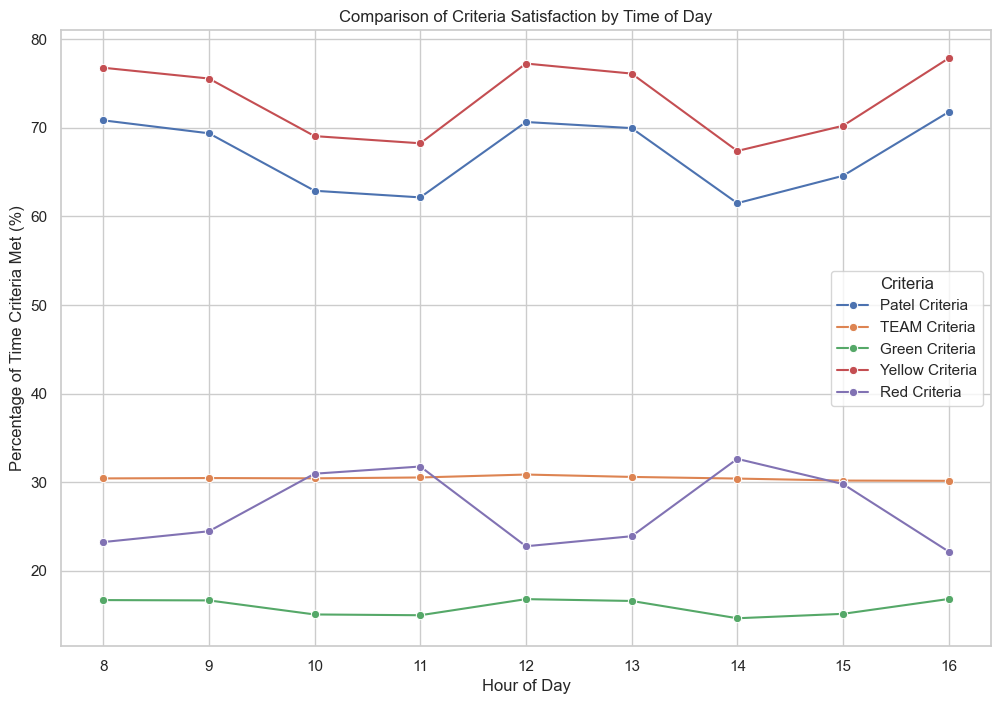

In [276]:
def criteria_time_of_day(df):
    # Group by hour and calculate the mean of each flag, which gives us the proportion of time the criteria is met
    time_of_day_df = df.groupby('recorded_hour').agg(
        patel_met=('patel_flag', 'mean'),
        team_met=('team_flag', 'mean'),
        all_green_no_red=('all_green_no_red', 'mean'),
        any_yellow_or_green_no_red=('any_yellow_or_green_no_red', 'mean'),
        any_red=('any_red', 'mean')
    ).reset_index()
    
    # Convert proportions to percentages
    time_of_day_df[['patel_met', 'team_met', 'all_green_no_red', 'any_yellow_or_green_no_red', 'any_red']] *= 100
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=time_of_day_df, x='recorded_hour', y='patel_met', label='Patel Criteria', marker='o')
    sns.lineplot(data=time_of_day_df, x='recorded_hour', y='team_met', label='TEAM Criteria', marker='o')
    sns.lineplot(data=time_of_day_df, x='recorded_hour', y='all_green_no_red', label='Green Criteria', marker='o')
    sns.lineplot(data=time_of_day_df, x='recorded_hour', y='any_yellow_or_green_no_red', label='Yellow Criteria', marker='o')
    sns.lineplot(data=time_of_day_df, x='recorded_hour', y='any_red', label='Red Criteria', marker='o')

    # Adding labels and title
    plt.xlabel('Hour of Day')
    plt.ylabel('Percentage of Time Criteria Met (%)')
    plt.title('Comparison of Criteria Satisfaction by Time of Day')
    plt.xticks(range(8, 17))  # Ensure all hours are shown
    plt.legend(title='Criteria')
    plt.grid(True)
    plt.show()

# Call the function with visualization_df
criteria_time_of_day(visualization_df)

### Subcomponent Failure

In [277]:
team_subcomponents = [
    'team_pulse_flag', 'team_lactate_flag', 'team_ne_flag',
    'team_fio2_flag', 'team_peep_flag', 'team_resp_rate_flag'
]
team_subcomponents = [
    'team_pulse_flag', 'team_lactate_flag', 'team_ne_flag',
    'team_fio2_flag', 'team_peep_flag', 'team_resp_rate_flag'
]

failed_df = visualization_df[visualization_df['team_flag'] == 0]
failure_rates = failed_df[team_subcomponents].mean() * 100

In [182]:
failed_df

,encounter_id,recorded_date,recorded_hour,time,time_biz,patel_map_flag,patel_sbp_flag,patel_pulse_flag,patel_resp_rate_flag,patel_spo2_flag,...,green_resp_spo2_flag,green_resp_rate_flag,green_fio2_flag,green_peep_flag,green_map_flag,green_ne_flag,green_pulse_flag,green_lactate_flag,green_hr_flag,green_flag
5,10932,2021-12-19,8,5,0,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
6,10932,2021-12-19,9,6,1,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
7,10932,2021-12-19,10,7,2,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
8,10932,2021-12-19,11,8,3,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,0
127,39566,2022-02-17,10,2,2,0,1,1,1,1,...,1,0,1,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319741,29999119,2022-01-10,12,59,22,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319742,29999119,2022-01-10,13,60,23,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319743,29999119,2022-01-10,14,61,24,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
319744,29999119,2022-01-10,15,62,25,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0


In [183]:
failure_rates

team_pulse_flag        99.132808
team_lactate_flag      54.176530
team_ne_flag           20.016667
team_fio2_flag         84.940094
team_peep_flag         99.579690
team_resp_rate_flag    98.798251
dtype: float64

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2323595239.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Failure Rate (%)', y='Subcomponent', data=failure_summary, palette='viridis')


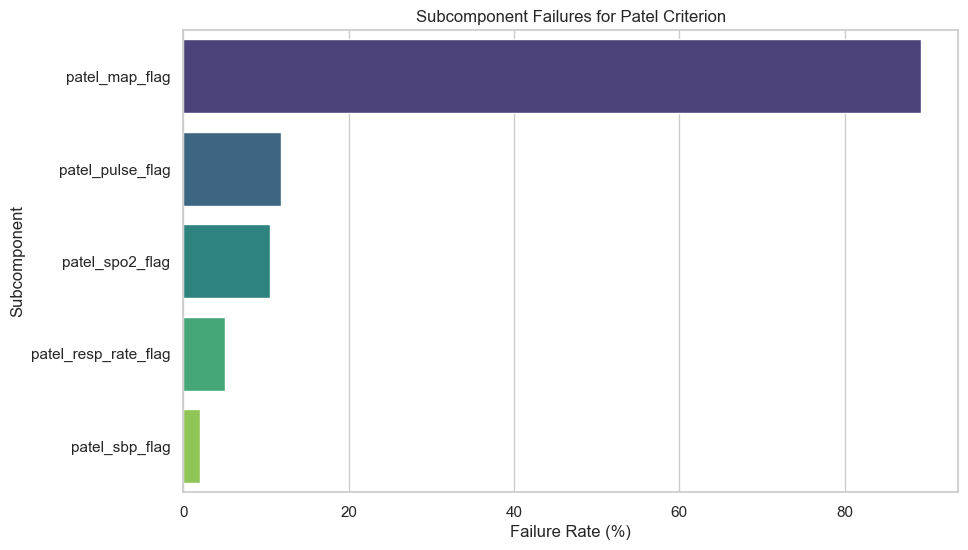

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2323595239.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Failure Rate (%)', y='Subcomponent', data=failure_summary, palette='viridis')


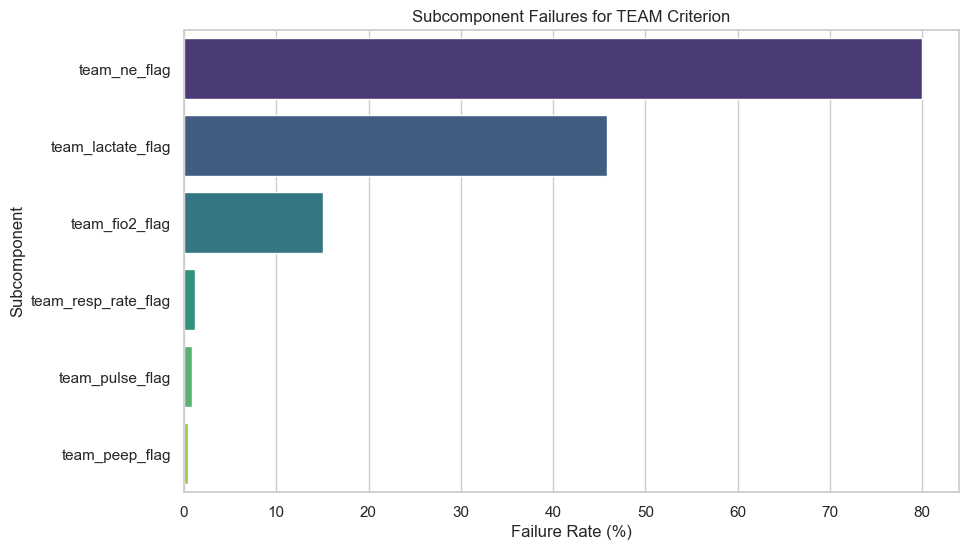

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2323595239.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Failure Rate (%)', y='Subcomponent', data=failure_summary, palette='viridis')


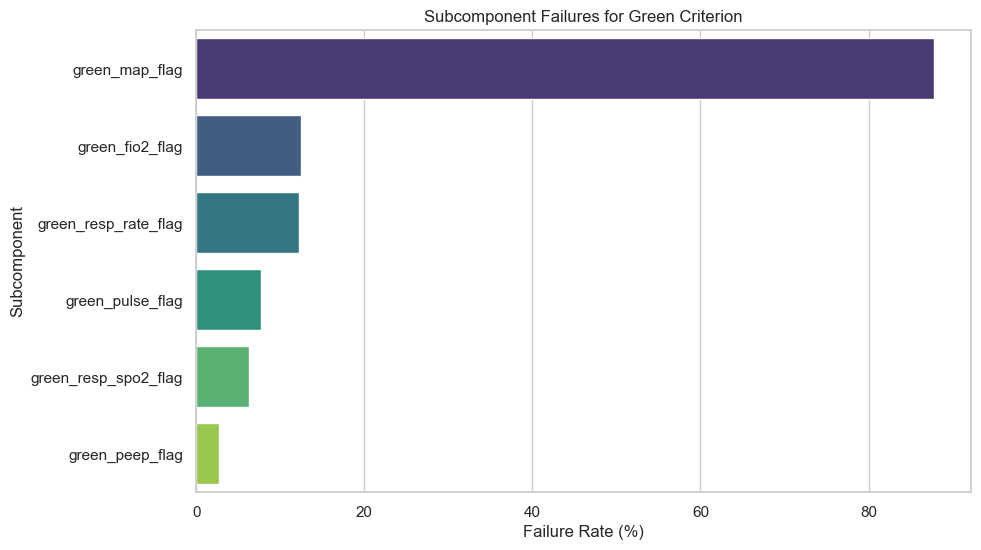

In [280]:
def analyze_subcomponent_failures(df, criterion_flag, subcomponents):
    # Filter the DataFrame to encounters where the criterion failed
    failed_df = df[df[criterion_flag] == 0]
    
    # Calculate the failure rate for each subcomponent
    failure_rates = (failed_df[subcomponents] == 0).mean() * 100
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Subcomponent': subcomponents,
        'Failure Rate (%)': failure_rates
    }).sort_values(by='Failure Rate (%)', ascending=False)
    
    return summary_df

# Define subcomponents for each criterion
patel_subcomponents = [
    'patel_map_flag', 'patel_sbp_flag', 'patel_pulse_flag',
    'patel_resp_rate_flag', 'patel_spo2_flag'
]

team_subcomponents = [
    'team_pulse_flag', 'team_lactate_flag', 'team_ne_flag',
    'team_fio2_flag', 'team_peep_flag', 'team_resp_rate_flag'
]

green_subcomponents = [
    'green_resp_spo2_flag', 'green_resp_rate_flag', 'green_fio2_flag',
    'green_peep_flag', 'green_map_flag',  'green_pulse_flag'
]

# Analyze failures for Patel, TEAM, and Green criteria
patel_failure_summary = analyze_subcomponent_failures(visualization_df, 'patel_flag', patel_subcomponents)
team_failure_summary = analyze_subcomponent_failures(visualization_df, 'team_flag', team_subcomponents)
green_failure_summary = analyze_subcomponent_failures(visualization_df, 'all_green_no_red', green_subcomponents)

# Plot the results for each criterion
def plot_failure_summary(failure_summary, criterion_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Failure Rate (%)', y='Subcomponent', data=failure_summary, palette='viridis')
    plt.title(f'Subcomponent Failures for {criterion_name} Criterion')
    plt.xlabel('Failure Rate (%)')
    plt.ylabel('Subcomponent')
    plt.show()

# Plot for Patel Criterion
plot_failure_summary(patel_failure_summary, 'Patel')

# Plot for TEAM Criterion
plot_failure_summary(team_failure_summary, 'TEAM')

# Plot for Green Criterion
plot_failure_summary(green_failure_summary, 'Green')

###  Average number of business hours each encounter is eligible

In [185]:
# Count the number of business hours each encounter was eligible for each criterion by counting where the flag is 1
hours_df = visualization_df.groupby('encounter_id').agg(
    patel_hours=('patel_flag', 'sum'),
    team_hours=('team_flag', 'sum'),
    green_hours=('green_flag', 'sum'),
    yellow_hours=('yellow_flag', 'sum'),
    red_hours=('red_flag', 'sum')
).reset_index()

# Calculate the average number of hours across all encounters
avg_hours_df = hours_df[['patel_hours', 'team_hours', 'green_hours', 'yellow_hours', 'red_hours']].mean()

# Sort the results in the order Patel, TEAM, Green, Yellow, Red
avg_hours_df = avg_hours_df[['patel_hours', 'team_hours', 'green_hours', 'yellow_hours', 'red_hours']]

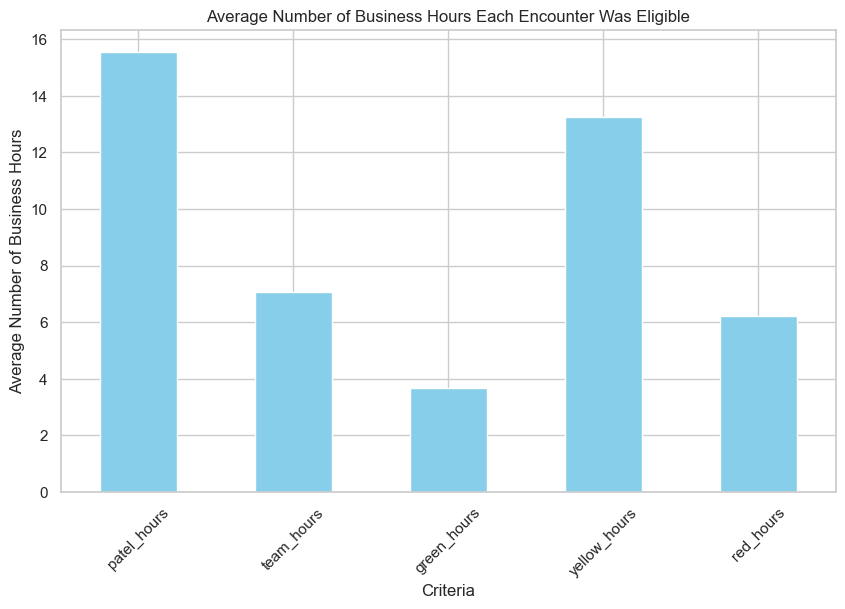

In [186]:
# Bar Chart
plt.figure(figsize=(10, 6))
avg_hours_df.plot(kind='bar', color='skyblue')
plt.title('Average Number of Business Hours Each Encounter Was Eligible')
plt.xlabel('Criteria')
plt.ylabel('Average Number of Business Hours')
plt.xticks(rotation=45)
plt.show()

In [187]:
hours_df

,encounter_id,patel_hours,team_hours,green_hours,yellow_hours,red_hours
0,10932,12,14,13,0,5
1,26255,13,27,14,9,4
2,39566,20,13,1,14,12
3,46076,18,27,19,3,5
4,46286,18,24,21,4,1
...,...,...,...,...,...,...
5131,29982535,12,9,3,9,2
5132,29993729,21,0,0,27,0
5133,29993999,4,0,0,4,1
5134,29997532,14,6,1,12,14


### QC

In [188]:
# Ensure admission_dttm is in datetime format
admissions_filtered['admission_dttm'] = pd.to_datetime(admissions_filtered['admission_dttm'])
# Create a month column
admissions_filtered['month'] = admissions_filtered['admission_dttm'].dt.to_period('M')
# Count the number of encounters each month
monthly_admission_counts = admissions_filtered.groupby('month')['encounter_id'].nunique().reset_index()
# Rename columns for clarity
monthly_admission_counts.columns = ['Month', 'Number of Encounters']

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2196599629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions_filtered['admission_dttm'] = pd.to_datetime(admissions_filtered['admission_dttm'])
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_26139/2196599629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions_filtered['month'] = admissions_filtered['admission_dttm'].dt.to_period('M')


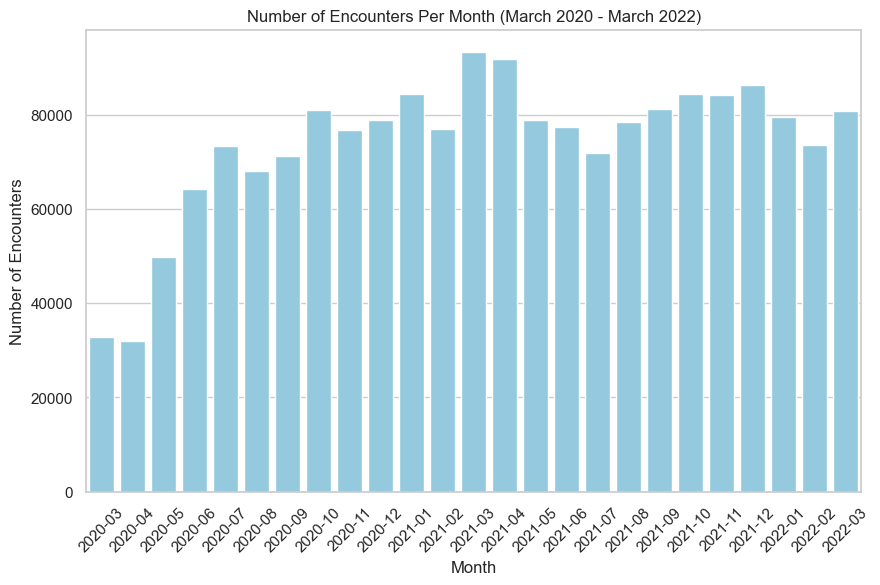

In [189]:
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Number of Encounters', data=monthly_admission_counts, color='skyblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Number of Encounters')
plt.title('Number of Encounters Per Month (March 2020 - March 2022)')

# Show the plot
plt.show()

## Ideas

- Create a heatmap where the x-axis represents hours of the day (e.g., 0 to 23), the y-axis represents dates, 
and the color intensity represents the number of encounters that were eligible during each hour of each day.